# **Tugas 3, EDA dan Klasifikasi pada transact class**

# **Kelompok 7**
1. Muhammad Daffa  Ma'arif (2305771)
2. Klara Ollivviera Augustine Gunawan (2306205)
3. Nashwa Nadria Futi (2308130)
4. Narendra Ridha Baihaqi (2308882)
5. Hafidz Tantowi (2308817)

# **Pendahuluan**

Pada tugas ini, analisis eksplorasi data (EDA) dan klasifikasi dilakukan pada dataset transact class. Proses ini bertujuan untuk memahami distribusi data, mengidentifikasi pola penting, dan membangun model prediktif yang mampu memprediksi hasil dengan akurasi yang optimal. Langkah-langkah yang diambil dalam tugas ini meliputi pembersihan data, pengolahan data yang hilang, eksplorasi korelasi antar fitur, dan penggunaan berbagai model klasifikasi. Hasil analisis diharapkan dapat memberikan wawasan yang lebih dalam mengenai faktor-faktor yang mempengaruhi transaksi dalam data ini dan meningkatkan performa prediksi model.

# **Load dataset**

In [900]:
import pandas as pd
import seaborn as sns
import numpy as np
import warnings as warn
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

warn.simplefilter(action='ignore', category=FutureWarning)

In [901]:
# Baca file teks ke dalam DataFrame
file_path = 'https://raw.githubusercontent.com/Schnee111/Classification-kel7/refs/heads/main/transact_train.txt'  # Ganti dengan nama file Anda
df = pd.read_csv(file_path, sep='|', header=0, na_values='?')  # `header=0` untuk membaca header dari baris pertama

# Tampilkan beberapa baris pertama untuk memastikan data diimpor dengan benar
df.head()

,sessionNo,startHour,startWeekday,duration,cCount,cMinPrice,cMaxPrice,cSumPrice,bCount,bMinPrice,...,availability,customerNo,maxVal,customerScore,accountLifetime,payments,age,address,lastOrder,order
0,1,6,5,0.000,1,59.99,59.99,59.99,1,59.99,...,NaN,1.0,600.0,70.0,21.0,1.0,43.0,1.0,49.0,y
1,1,6,5,11.940,1,59.99,59.99,59.99,1,59.99,...,completely orderable,1.0,600.0,70.0,21.0,1.0,43.0,1.0,49.0,y
2,1,6,5,39.887,1,59.99,59.99,59.99,1,59.99,...,completely orderable,1.0,600.0,70.0,21.0,1.0,43.0,1.0,49.0,y
3,2,6,5,0.000,0,NaN,NaN,NaN,0,NaN,...,completely orderable,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,y
4,2,6,5,15.633,0,NaN,NaN,NaN,0,NaN,...,completely orderable,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,y


kami hanya mengambil data terbaru untuk setiap sesi, jika ada missing values, maka ambil values dari data data sebelumnya

In [902]:
# Urutkan data berdasarkan sessionNo dan duration untuk mengambil record terbaru
df_sorted = df.sort_values(by=['sessionNo', 'duration'], ascending=[True, False])

# Isi nilai yang hilang dengan data dari record sebelumnya dalam grup session, telusuri hingga record pertama
df_filled = df_sorted.groupby('sessionNo').apply(lambda x: x.ffill()).reset_index(drop=True)

# Mengisi bStep dengan nilai maksimum pada setiap sesi
df_filled['bStep'] = df_filled.groupby('sessionNo')['bStep'].transform('max')

# Ambil record terbaru yang telah diisi untuk setiap sessionNo
df_latest = df_filled.groupby('sessionNo').first().reset_index()

# Hanya ambil record terbaru dengan nilai yang telah diisi
df = df_filled.loc[df_filled['sessionNo'].isin(df_latest['sessionNo'])].drop_duplicates(subset='sessionNo', keep='first')

# Menampilkan DataFrame yang telah dimodifikasi
print("DataFrame setelah pengisian dan modifikasi:")
df.head()


C:\Users\Daffa\AppData\Local\Temp\ipykernel_25280\4274437462.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filled = df_sorted.groupby('sessionNo').apply(lambda x: x.ffill()).reset_index(drop=True)


DataFrame setelah pengisian dan modifikasi:


,sessionNo,startHour,startWeekday,duration,cCount,cMinPrice,cMaxPrice,cSumPrice,bCount,bMinPrice,...,availability,customerNo,maxVal,customerScore,accountLifetime,payments,age,address,lastOrder,order
0,1,6,5,39.887,1,59.99,59.99,59.99,1,59.99,...,completely orderable,1.0,600.0,70.0,21.0,1.0,43.0,1.0,49.0,y
3,2,6,5,94.469,0,NaN,NaN,NaN,0,NaN,...,completely orderable,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,y
8,3,6,5,341.613,11,9.99,29.99,109.95,2,9.99,...,completely orderable,3.0,1800.0,475.0,302.0,12.0,45.0,1.0,11.0,y
13,4,6,5,42.812,4,4.99,4.99,19.96,1,4.99,...,completely not orderable,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n
15,5,6,5,2816.046,45,12.99,179.95,1093.72,4,19.99,...,completely orderable,4.0,800.0,503.0,18.0,1.0,46.0,1.0,40.0,y


## **Penanganan Missing Values dan Zero Values**

### **Cek Missing dan Zero Values untuk setiap fitur**

In [903]:
print("Jumlah missing values per kolom:")
print(df.isnull().sum())

Jumlah missing values per kolom:
sessionNo              0
startHour              0
startWeekday           0
duration               0
cCount                 0
cMinPrice            325
cMaxPrice            325
cSumPrice            325
bCount                 0
bMinPrice            682
bMaxPrice            682
bSumPrice            682
bStep              11084
onlineStatus       10973
availability       12781
customerNo         22639
maxVal             22954
customerScore      22954
accountLifetime    22954
payments           22639
age                22667
address            22639
lastOrder          22639
order                  0
dtype: int64


In [904]:
numerical_features = ['duration', 'cCount', 'cMinPrice', 'cMaxPrice', 'cSumPrice', 'bCount', 'bMinPrice', 'bMaxPrice', 'bSumPrice',
                      'maxVal', 'accountLifetime', 'customerScore','payments', 'customerNo', 'age', 'address', 'lastOrder']
zero_values = (df[numerical_features] == 0).sum()
zero_values = zero_values[zero_values > 0]
print("Kolom dengan zero values dan jumlahnya:")
print(zero_values)

Kolom dengan zero values dan jumlahnya:
duration           1245
cCount              179
cMinPrice           364
cMaxPrice             6
cSumPrice             6
bCount              478
bMinPrice           178
bMaxPrice            18
bSumPrice            18
maxVal              123
accountLifetime     224
customerScore         5
payments           2633
dtype: int64


### **Menghapus field yang dianggap kurang penting dan terlalu banyak Missing Values**

Mempertimbangkan jumlah missing values dan jenis informasi yang terkandung dalam kolom-kolom tersebut, berikut beberapa pertimbangan lebih detail apakah suatu kolom tersebut sebaiknya dihapus atau dipertahankan.

* Kolom dengan Missing Values Tinggi:

    * onlineStatus, availability:

        onlineStatus dan availability mungkin dapat memberikan informasi penting tentang status barang saat sesi berlangsung (misalnya, apakah barang tersebut tersedia untuk dibeli).
        
        Untuk onlineStatus, jika ingin mempertahankannya, kita bisa mengisinya dengan nilai default seperti "unknown" jika kita yakin status ini masih relevan dalam menentukan apakah pelanggan melakukan pembelian.

    * customerNo, maxVal, customerScore, accountLifetime, payments, age, address, lastOrder:

        customerScore, accountLifetime, dan lastOrder mungkin penting karena memberikan informasi tentang kebiasaan dan riwayat pelanggan. Namun, karena missing values terlalu banyak, sulit untuk memperkirakan data ini dengan tepat.

        customerNo, address, dan payments bisa dihapus karena tidak langsung relevan dengan keputusan pembelian.

        Jika kita ingin menggunakan informasi pelanggan, kolom customerScore bisa dipertahankan (dengan mengisi missing values dengan median atau default).

* Kolom dengan Missing Values Sedikit:

    * cMinPrice, cMaxPrice, cSumPrice, bMinPrice, bMaxPrice, bSumPrice:
    
        Kolom-kolom ini penting karena mencakup informasi tentang harga dari produk yang diklik atau dilihat, yang dapat menunjukkan minat dan potensi pembelian.
        
        Kita bisa mengisi missing values pada kolom ini dengan median, karena harga tidak biasanya dipengaruhi oleh outliers dengan cara yang signifikan.

Beberapa kolom yang mungkin penting untuk melakukan prediksi tetapi memiliki banyak mising values yang sulit untuk diperkirakan nilai yang tepat, kami memutuskan untuk menghapusnya

In [905]:
# Menghapus kolom yang dianggap kurang penting atau terlalu banyak missing values
cols_to_drop = ['maxVal', 'accountLifetime', 'customerScore','payments', 'customerNo', 'age', 'address', 'lastOrder']
df.drop(columns=cols_to_drop, inplace=True)

In [906]:
# Mengonversi kolom 'order' menjadi numerik
df['order'] = df['order'].map({'y': 1, 'n': 0})

df['onlineStatus'] = df['onlineStatus'].map({'y': 1, 'n': 0})

df['availability'] = df['availability'].map({'completely not orderable': 0, 'mainly not orderable': 1, 'mainly not determinable': 2, 
                                             'mixed' : 3, 'mainly orderable': 4, 'completely orderable': 5})

### **Zero Values pada Field duration**

karena tidak ada missing values pada field furation, dan terdapat 1245 data dengan nilai 0 pada field duration, kami akan mengeceknya terlebih dahulu

In [907]:
print(len(df[(df['duration'] == 0)]))
df[(df['duration'] == 0)].head(20)

1245


,sessionNo,startHour,startWeekday,duration,cCount,cMinPrice,cMaxPrice,cSumPrice,bCount,bMinPrice,bMaxPrice,bSumPrice,bStep,onlineStatus,availability,order
23,6,6,5,0.0,1,129.99,129.99,129.99,1,129.99,129.99,129.99,NaN,NaN,NaN,0
41,8,6,5,0.0,1,59.99,59.99,59.99,1,59.99,59.99,59.99,NaN,NaN,NaN,0
380,51,6,5,0.0,1,169.00,169.00,169.00,1,169.00,169.00,169.00,NaN,NaN,NaN,0
424,59,6,5,0.0,1,129.99,129.99,129.99,1,129.99,129.99,129.99,NaN,NaN,NaN,0
664,93,6,5,0.0,1,99.99,99.99,99.99,1,99.99,99.99,99.99,NaN,NaN,NaN,0
730,105,6,5,0.0,1,5.00,5.00,5.00,1,5.00,5.00,5.00,NaN,NaN,NaN,0
760,112,6,5,0.0,1,169.00,169.00,169.00,1,169.00,169.00,169.00,NaN,NaN,NaN,0
799,122,6,5,0.0,1,5.99,5.99,5.99,1,5.99,5.99,5.99,NaN,NaN,NaN,0
980,144,6,5,0.0,1,99.99,99.99,99.99,1,99.99,99.99,99.99,NaN,NaN,NaN,0
1296,190,6,5,0.0,1,99.99,99.99,99.99,1,99.99,99.99,99.99,NaN,NaN,NaN,0


In [908]:
df[(df['duration'] == 0)].tail(20)

,sessionNo,startHour,startWeekday,duration,cCount,cMinPrice,cMaxPrice,cSumPrice,bCount,bMinPrice,bMaxPrice,bSumPrice,bStep,onlineStatus,availability,order
414528,48396,17,7,0.0,1,99.99,99.99,99.99,1,99.99,99.99,99.99,NaN,NaN,NaN,0
414973,48447,17,7,0.0,1,319.99,319.99,319.99,1,319.99,319.99,319.99,NaN,NaN,NaN,0
415122,48469,17,7,0.0,1,49.99,49.99,49.99,1,49.99,49.99,49.99,NaN,NaN,NaN,0
415911,48561,17,7,0.0,1,99.99,99.99,99.99,1,99.99,99.99,99.99,NaN,NaN,NaN,0
418299,48809,17,7,0.0,1,6.99,6.99,6.99,1,6.99,6.99,6.99,NaN,NaN,NaN,0
418946,48885,17,7,0.0,1,99.99,99.99,99.99,1,99.99,99.99,99.99,NaN,NaN,NaN,0
419413,48939,17,7,0.0,1,99.99,99.99,99.99,1,99.99,99.99,99.99,NaN,NaN,NaN,0
419649,48964,17,7,0.0,1,99.99,99.99,99.99,1,99.99,99.99,99.99,NaN,NaN,NaN,0
419800,48978,17,7,0.0,1,6.99,6.99,6.99,1,6.99,6.99,6.99,NaN,NaN,NaN,0
420059,49000,18,7,0.0,1,169.00,169.00,169.00,1,169.00,169.00,169.00,NaN,NaN,NaN,0


karena data dengan durasi 0 masih memiliki informasi seperti count, maka kami dapat mengimputasi berdasarkan nilai tersebut

In [909]:
df['cCount'].describe()

count    50000.000000
mean        20.198200
std         28.451429
min          0.000000
25%          4.000000
50%         10.000000
75%         24.000000
max        200.000000
Name: cCount, dtype: float64

mengklasifikasikan rentang cCount untuk imputasi duration

In [910]:
# Misalkan df adalah DataFrame Anda
bins = [0, 4, 10, 24, 200]  # Rentang yang diusulkan
labels = ['Very Low', 'Low', 'Medium', 'High']

# Mengklasifikasikan nilai cCount
df['count_class'] = pd.cut(df['cCount'], bins=bins, labels=labels, right=True)

# Menghitung rata-rata durasi berdasarkan kelas count
durasi_by_count_class = df.groupby('count_class')['duration'].mean().reset_index()

# Menampilkan hasil
print(durasi_by_count_class)


  count_class     duration
0    Very Low   293.880670
1         Low   830.778721
2      Medium  1506.327829
3        High  3432.052079


In [911]:
print(len(df[df['duration'] == 0]))

1245


imputasi duration dengan nilai mean berdasarkan rentang count

In [912]:
# Mengisi nilai durasi yang nol dengan rata-rata berdasarkan kelas count
for count_class in df['count_class'].unique():
    mean_duration = df.loc[df['count_class'] == count_class, 'duration'].mean()
    df.loc[(df['duration'] == 0) & (df['count_class'] == count_class), 'duration'] = mean_duration


lalu menghapus kolom bantu dan pengecekan sisa durasi

In [913]:
# Menghapus kolom count_class
df.drop(columns=['count_class'], inplace=True)
print(len(df[df['duration'] == 0]))

45


sisanya adalah data yang memiliki missing values di hampir semua field penting

In [914]:
df[(df['duration'] == 0)].tail(20)

,sessionNo,startHour,startWeekday,duration,cCount,cMinPrice,cMaxPrice,cSumPrice,bCount,bMinPrice,bMaxPrice,bSumPrice,bStep,onlineStatus,availability,order
194820,23250,13,6,0.0,0,NaN,NaN,NaN,0,NaN,NaN,NaN,1.0,1.0,5.0,0
206762,24648,14,6,0.0,0,NaN,NaN,NaN,0,NaN,NaN,NaN,1.0,1.0,5.0,0
214415,25459,15,6,0.0,0,NaN,NaN,NaN,0,NaN,NaN,NaN,1.0,1.0,5.0,0
214624,25479,15,6,0.0,0,NaN,NaN,NaN,0,NaN,NaN,NaN,1.0,1.0,5.0,0
235119,27777,16,6,0.0,0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,1.0,5.0,0
285266,33307,20,6,0.0,0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,1.0,5.0,0
313702,36569,5,7,0.0,0,NaN,NaN,NaN,0,NaN,NaN,NaN,2.0,1.0,5.0,0
321253,37480,8,7,0.0,0,NaN,NaN,NaN,0,NaN,NaN,NaN,1.0,1.0,5.0,0
324794,37870,9,7,0.0,0,NaN,NaN,NaN,0,NaN,NaN,NaN,1.0,1.0,5.0,0
327845,38245,9,7,0.0,0,NaN,NaN,NaN,0,NaN,NaN,NaN,1.0,1.0,5.0,0


sehingga kami memutuskan untuk menghapusnya

In [915]:
# Menghapus baris di mana duration bernilai 0 tetapi terdapat order
df = df[~(df['duration'] == 0)]

In [916]:
print(len(df[df['duration'] == 0]))

0


### **Mengisi Missing Values dengan median pada field numerik**

pada beberapa field yang bertipe data numerik seperti count, min max dan sum price, kami mengisi missing values dengan median berdasarkan rentang durasi

In [917]:
skew_values = df['duration'].skew()
print(skew_values)

3.8653177747980156


karena skewness pada data duration cukup tinggi, kami melakukan transformasi log pada kolom durasi sebelum melakukan pembagian ke dalam kategori, lalu mengisi missing values pada field-field tersebut dengan nilai mediannya untuk setiap kategori durasi

In [918]:
# Transformasi log dan mengkategorikan berdasarkan log
df['log_duration'] = np.log1p(df['duration'])
df['kategori_durasi'] = pd.cut(df['log_duration'], bins=4, labels=['sangat_pendek', 'pendek', 'sedang', 'panjang'])

# Menghitung nilai median untuk setiap kategori durasi
impute_values = df.groupby('kategori_durasi')[['cCount', 'cMinPrice', 'cMaxPrice', 'cSumPrice', 
                                               'bCount', 'bMinPrice', 'bMaxPrice', 'bSumPrice']].transform('median')

# Mengisi nilai yang hilang berdasarkan kategori durasi
df[['cCount', 'cMinPrice', 'cMaxPrice', 'cSumPrice', 
    'bCount', 'bMinPrice', 'bMaxPrice', 'bSumPrice']] = df[['cCount', 'cMinPrice', 'cMaxPrice', 'cSumPrice', 
                                                            'bCount', 'bMinPrice', 'bMaxPrice', 'bSumPrice']].fillna(impute_values)

# Menghapus kolom bantu
df.drop(columns=['kategori_durasi', 'log_duration'], inplace=True)

In [919]:
# Verifikasi jumlah missing values setelah proses
print("\nJumlah missing values per kolom setelah proses:")
print(df.isnull().sum())



Jumlah missing values per kolom setelah proses:
sessionNo           0
startHour           0
startWeekday        0
duration            0
cCount              0
cMinPrice           0
cMaxPrice           0
cSumPrice           0
bCount              0
bMinPrice           0
bMaxPrice           0
bSumPrice           0
bStep           11072
onlineStatus    10973
availability    12896
order               0
dtype: int64


masih banyak missing values pada field kategori seperti bStep, onlinestatus, dan availability, kami akan menangani ini dengan KNN imputer setelah penanganan zero values lainnya

ada beberapa data yang sum dan min atau max price nya 0, tetapi melakukan order, kami memutuskan untuk menghapus data data tersebut karena terbilang sangat sedikit, dan dapat mempengaruhi model prediksi

In [920]:
anomaly = df[(df['bSumPrice'] == 0) & (df['order'] == 1)]
print("Data dengan sumprice 0 dan order y :", len(anomaly))

Data dengan sumprice 0 dan order y : 0


hapus data dengan order "y" dan c atau b SumPrice 0

In [921]:
df = df[~((df['order'] == 1) & ((df['cSumPrice'] == 0) | (df['bSumPrice'] == 0)))]

In [922]:
anomaly = df[(df['cCount'] < df['bCount'])]
print("jumlah data dengan barang yang masuk keranjang melebihi barang yang di klik :", len(anomaly))

jumlah data dengan barang yang masuk keranjang melebihi barang yang di klik : 0


In [923]:
anomaly_c = df[df['cMinPrice'] > df['cMaxPrice']]
anomaly_b = df[df['bMinPrice'] > df['bMaxPrice']]
print("Data dengan cMinPrice lebih besar dari cMaxPrice:", len(anomaly_c))
print("Data dengan bMinPrice lebih besar dari bMaxPrice:", len(anomaly_b))

Data dengan cMinPrice lebih besar dari cMaxPrice: 0
Data dengan bMinPrice lebih besar dari bMaxPrice: 0


### **Cek sisa zero values pada field numeric**

In [924]:
numerical_features = ['duration', 'cCount', 'cMinPrice', 'cMaxPrice', 'cSumPrice', 'bCount', 'bMinPrice', 'bMaxPrice', 'bSumPrice']
zero_values = (df[numerical_features] == 0).sum()
zero_values = zero_values[zero_values > 0]
print("Kolom dengan zero values dan jumlahnya:")
print(zero_values)

Kolom dengan zero values dan jumlahnya:
cCount       134
cMinPrice    364
cMaxPrice      6
cSumPrice      6
bCount       433
bMinPrice    178
bMaxPrice     18
bSumPrice     18
dtype: int64


terlihat masih ada sisa zero values pada beberapa field numerik, pertama kami mempertimbangkan untuk mengisi bMin dengan cMin karena kedua field tersebut kami nilai sangat terkait, dan jumlah anomali data yang tidak banyak

cek data yang memiliki zero values pada kedua field minprice

In [925]:
print(len(df[(df['bMinPrice'] == 0) & (df['cMinPrice'] == 0)]))

178


In [926]:
df[(df['bMinPrice'] == 0) & (df['bMinPrice'] == 0)].head(20)

,sessionNo,startHour,startWeekday,duration,cCount,cMinPrice,cMaxPrice,cSumPrice,bCount,bMinPrice,bMaxPrice,bSumPrice,bStep,onlineStatus,availability,order
855,129,6,5,553.975,27,0.0,40.00,435.00,1,0.0,0.00,0.00,1.0,1.0,4.0,0
8246,1069,8,5,13001.884,115,0.0,199.99,1551.13,11,0.0,16.99,95.91,2.0,1.0,5.0,0
9210,1174,8,5,999.797,50,0.0,15.00,279.99,3,0.0,7.00,8.00,NaN,NaN,NaN,0
10541,1360,8,5,3814.762,72,0.0,319.99,2704.70,15,0.0,319.99,1028.91,5.0,1.0,5.0,1
12332,1588,9,5,1537.989,25,0.0,29.99,468.58,8,0.0,29.99,153.86,4.0,1.0,5.0,1
14636,1852,9,5,14834.034,165,0.0,899.00,2414.50,17,0.0,20.00,119.92,5.0,1.0,0.0,1
18339,2271,9,5,16278.413,14,0.0,5.00,43.00,3,0.0,5.00,5.00,4.0,1.0,5.0,1
26308,3198,10,5,767.624,7,0.0,29.99,83.98,2,0.0,29.99,29.99,2.0,1.0,5.0,1
27833,3378,10,5,443.277,7,0.0,33.99,150.95,2,0.0,33.99,33.99,4.0,1.0,5.0,0
28924,3508,10,5,6750.572,125,0.0,29.99,892.79,9,0.0,14.99,49.95,4.0,1.0,5.0,1


karena field tersebut saling terkait (sama sama memiliki zero values untuk tiap data), maka kami akan mengimputasi cMin dengan bMin terlebih dahulu, lalu mengimputasi sisa yang 0 dengan median atau mean

### **Imputasi cMin dengan bMin** 

In [927]:
# Mengganti nilai 0 di cMinPrice dengan nilai dari bMinPrice
df.loc[df['cMinPrice'] == 0, 'cMinPrice'] = df['bMinPrice']

In [928]:
numerical_features = ['duration', 'cCount', 'cMinPrice', 'cMaxPrice', 'cSumPrice', 'bCount', 'bMinPrice', 'bMaxPrice', 'bSumPrice']
zero_values = (df[numerical_features] == 0).sum()
zero_values = zero_values[zero_values > 0]
print("Kolom dengan zero values dan jumlahnya:")
print(zero_values)

Kolom dengan zero values dan jumlahnya:
cCount       134
cMinPrice    178
cMaxPrice      6
cSumPrice      6
bCount       433
bMinPrice    178
bMaxPrice     18
bSumPrice     18
dtype: int64


karena cMin tadi kita imputasi dengan bMin, maka yang tersisa adalah data yang memiliki cMin dan bMin 0

### **Imputasi cCount dan bCount yang memiliki zero values**

selanjutnya kami mengimputasi bCount dan cCount yang masih memiliki zero values berdasrkan sum min dan max pricenya

In [929]:
# Menghitung estimasi cCount menggunakan cMinPrice dan cMaxPrice
df['cCount'] = df.apply(lambda row: 
                        row['cSumPrice'] / ((row['cMinPrice'] + row['cMaxPrice']) / 2) 
                        if row['cCount'] == 0 and row['cMinPrice'] > 0 and row['cMaxPrice'] > row['cMinPrice'] 
                        else row['cSumPrice'] / row['cMinPrice'] 
                        if row['cCount'] == 0 and row['cMinPrice'] > 0 
                        else row['cCount'], 
                        axis=1)

# Menghitung estimasi bCount menggunakan bMinPrice dan bMaxPrice
df['bCount'] = df.apply(lambda row: 
                        row['bSumPrice'] / ((row['bMinPrice'] + row['bMaxPrice']) / 2) 
                        if row['bCount'] == 0 and row['bMinPrice'] > 0 and row['bMaxPrice'] > row['bMinPrice'] 
                        else row['bSumPrice'] / row['bMinPrice'] 
                        if row['bCount'] == 0 and row['bMinPrice'] > 0 
                        else row['bCount'], 
                        axis=1)

tampilkan sisa zero values

In [930]:
numerical_features = ['duration', 'cCount', 'cMinPrice', 'cMaxPrice', 'cSumPrice', 'bCount', 'bMinPrice', 'bMaxPrice', 'bSumPrice']
zero_values = (df[numerical_features] == 0).sum()
zero_values = zero_values[zero_values > 0]
print("Kolom dengan zero values dan jumlahnya:")
print(zero_values)

Kolom dengan zero values dan jumlahnya:
cMinPrice    178
cMaxPrice      6
cSumPrice      6
bMinPrice    178
bMaxPrice     18
bSumPrice     18
dtype: int64


### **Imputasi cMin dan bMin yang tersisa**

sisanya kami menggunakan median global, tetapi jika melebihi nilai max, maka kami gunakan nilai max nya untuk imputasi

In [931]:
# Menghitung median global untuk cMinPrice dan bMinPrice
global_median_cMinPrice = df['cMinPrice'].median()
global_median_bMinPrice = df['bMinPrice'].median()

# Imputasi cMinPrice dengan kondisi
df['cMinPrice'] = df.apply(
    lambda row: min(global_median_cMinPrice, row['cMaxPrice']) if row['cMinPrice'] == 0 else row['cMinPrice'],
    axis=1
)

# Imputasi bMinPrice dengan kondisi
df['bMinPrice'] = df.apply(
    lambda row: min(global_median_bMinPrice, row['bMaxPrice']) if row['bMinPrice'] == 0 else row['bMinPrice'],
    axis=1
)


sisa zero values

In [932]:
numerical_features = ['duration', 'cCount', 'cMinPrice', 'cMaxPrice', 'cSumPrice', 'bCount', 'bMinPrice', 'bMaxPrice', 'bSumPrice']
zero_values = (df[numerical_features] == 0).sum()
zero_values = zero_values[zero_values > 0]
print("Kolom dengan zero values dan jumlahnya:")
print(zero_values)

Kolom dengan zero values dan jumlahnya:
cMinPrice     6
cMaxPrice     6
cSumPrice     6
bMinPrice    18
bMaxPrice    18
bSumPrice    18
dtype: int64


### **Imputasi harga produk pada keranjang (b)** 

kami mempertimbangkan untuk megisinya berdasarkan nilai cMinPrice yang dikalikan dengan rasio bCount terhadap cCount, dan melakukan proses yang sama terhadap max dan sum price

In [933]:
# Imputasi bMinPrice
df.loc[(df['bMinPrice'] == 0) & (df['bCount'] > 0), 'bMinPrice'] = df['cMinPrice'] * (df['bCount'] / df['cCount'])

# Imputasi bMaxPrice
df.loc[(df['bMaxPrice'] == 0) & (df['bCount'] > 0), 'bMaxPrice'] = df['cMaxPrice'] * (df['bCount'] / df['cCount'])

# Imputasi bSumPrice
df.loc[(df['bSumPrice'] == 0) & (df['bCount'] > 0), 'bSumPrice'] = df['cSumPrice'] * (df['bCount'] / df['cCount'])


In [934]:
numerical_features = ['duration', 'cCount', 'cMinPrice', 'cMaxPrice', 'cSumPrice', 'bCount', 'bMinPrice', 'bMaxPrice', 'bSumPrice']
zero_values = (df[numerical_features] == 0).sum()
zero_values = zero_values[zero_values > 0]
print("Kolom dengan zero values dan jumlahnya:")
print(zero_values)

Kolom dengan zero values dan jumlahnya:
cMinPrice    6
cMaxPrice    6
cSumPrice    6
bMinPrice    6
bMaxPrice    6
bSumPrice    6
dtype: int64


### **Imputasi sisa data**

maka, yang tersisa adalah data berikut, kami coba imputasi dengan mean berdasarkan kategori count, seperti imputasi durasi tadi

In [935]:
df[(df['bMinPrice'] == 0) & (df['cMinPrice'] == 0)].head(20)

,sessionNo,startHour,startWeekday,duration,cCount,cMinPrice,cMaxPrice,cSumPrice,bCount,bMinPrice,bMaxPrice,bSumPrice,bStep,onlineStatus,availability,order
99746,11889,18,5,60.300,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,1.0,5.0,0
179852,21518,11,6,176.487,3.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,1.0,3.0,0
235417,27811,16,6,63.929,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5.0,1.0,5.0,0
287666,33557,20,6,10.455,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,0
347190,41140,12,7,12.603,3.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,NaN,NaN,NaN,0
384075,45117,15,7,53.698,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,5.0,0


In [936]:
# Langkah 1: Klasifikasikan nilai cCount dan bCount menjadi kategori
bins = [0, 4, 10, 24, 200]  # Rentang yang diusulkan
labels = ['Very Low', 'Low', 'Medium', 'High']

# Mengklasifikasikan nilai cCount
df['cCount_class'] = pd.cut(df['cCount'], bins=bins, labels=labels, right=True)

# Mengklasifikasikan nilai bCount
df['bCount_class'] = pd.cut(df['bCount'], bins=bins, labels=labels, right=True)

# Langkah 2: Menghitung rata-rata harga untuk cMinPrice, cMaxPrice, cSumPrice berdasarkan kategori cCount
mean_values_c = df.groupby('cCount_class')[['cMinPrice', 'cMaxPrice', 'cSumPrice']].mean().reset_index()

# Langkah 3: Mengisi nilai cMinPrice, cMaxPrice, cSumPrice yang kosong (0) dengan nilai dari mean_values_c
for count_class in df['cCount_class'].unique():
    # Mengambil rata-rata harga berdasarkan kelas cCount
    mean_cMin = mean_values_c.loc[mean_values_c['cCount_class'] == count_class, 'cMinPrice'].values[0]
    mean_cMax = mean_values_c.loc[mean_values_c['cCount_class'] == count_class, 'cMaxPrice'].values[0]
    mean_cSum = mean_values_c.loc[mean_values_c['cCount_class'] == count_class, 'cSumPrice'].values[0]

    # Mengisi nilai 0 pada cMinPrice, cMaxPrice, cSumPrice
    df.loc[(df['cMinPrice'] == 0) & (df['cCount_class'] == count_class), 'cMinPrice'] = mean_cMin
    df.loc[(df['cMaxPrice'] == 0) & (df['cCount_class'] == count_class), 'cMaxPrice'] = mean_cMax
    df.loc[(df['cSumPrice'] == 0) & (df['cCount_class'] == count_class), 'cSumPrice'] = mean_cSum

# Langkah 4: Menghitung rata-rata harga untuk bMinPrice, bMaxPrice, bSumPrice berdasarkan kategori bCount
mean_values_b = df.groupby('bCount_class')[['bMinPrice', 'bMaxPrice', 'bSumPrice']].mean().reset_index()

# Langkah 5: Mengisi nilai bMinPrice, bMaxPrice, bSumPrice yang kosong (0) dengan nilai dari mean_values_b
for count_class in df['bCount_class'].unique():
    # Mengambil rata-rata harga berdasarkan kelas bCount
    mean_bMin = mean_values_b.loc[mean_values_b['bCount_class'] == count_class, 'bMinPrice'].values[0]
    mean_bMax = mean_values_b.loc[mean_values_b['bCount_class'] == count_class, 'bMaxPrice'].values[0]
    mean_bSum = mean_values_b.loc[mean_values_b['bCount_class'] == count_class, 'bSumPrice'].values[0]

    # Mengisi nilai 0 pada bMinPrice, bMaxPrice, bSumPrice
    df.loc[(df['bMinPrice'] == 0) & (df['bCount_class'] == count_class), 'bMinPrice'] = mean_bMin
    df.loc[(df['bMaxPrice'] == 0) & (df['bCount_class'] == count_class), 'bMaxPrice'] = mean_bMax
    df.loc[(df['bSumPrice'] == 0) & (df['bCount_class'] == count_class), 'bSumPrice'] = mean_bSum

# Langkah 6: Menghapus kolom bantu
df.drop(columns=['cCount_class', 'bCount_class'], inplace=True)

In [937]:
numerical_features = ['duration', 'cCount', 'cMinPrice', 'cMaxPrice', 'cSumPrice', 'bCount', 'bMinPrice', 'bMaxPrice', 'bSumPrice']
zero_values = (df[numerical_features] == 0).sum()
zero_values = zero_values[zero_values > 0]
print("Kolom dengan zero values dan jumlahnya:")
print(zero_values)

Kolom dengan zero values dan jumlahnya:
Series([], dtype: int64)


In [938]:
len(df[df['bMaxPrice'] > df['cMaxPrice']])

138

In [939]:
df = df[~(df['bMinPrice'] < df['cMinPrice'])]

In [940]:
len(df[df['bMinPrice'] < df['cMinPrice']])

0

In [941]:
len(df[df['bMaxPrice'] > df['cMaxPrice']])


118

In [942]:
df = df[~(df['bMaxPrice'] > df['cMaxPrice'])]

In [943]:
len(df[df['bMaxPrice'] > df['cMaxPrice']])

0

In [944]:
print(len(df[(df['cCount'] > 1) & (df['cMinPrice'] == df['cMaxPrice']) & (df['cSumPrice'] < df['cMinPrice']*df['cCount'])]))
df[(df['cCount'] > 1) & (df['cMinPrice'] == df['cMaxPrice']) & (df['cSumPrice'] < df['cMinPrice']*df['cCount'])].head()

4158


,sessionNo,startHour,startWeekday,duration,cCount,cMinPrice,cMaxPrice,cSumPrice,bCount,bMinPrice,bMaxPrice,bSumPrice,bStep,onlineStatus,availability,order
383,52,6,5,54.403,3.0,4.99,4.99,9.98,1.0,4.99,4.99,4.99,5.0,1.0,5.0,0
506,69,6,5,397.896,10.0,19.99,19.99,159.92,2.0,19.99,19.99,39.98,5.0,1.0,5.0,1
518,71,6,5,239.616,4.0,39.99,39.99,79.98,1.0,39.99,39.99,39.99,1.0,1.0,5.0,1
579,82,6,5,4.609,2.0,599.99,599.99,599.99,2.0,599.99,599.99,599.99,NaN,NaN,NaN,0
865,131,6,5,4.827,2.0,599.99,599.99,599.99,2.0,599.99,599.99,599.99,NaN,NaN,NaN,0


### **Cek Distribusi Data**

sebelum imputasi field kategori, karena kita akan menggunakan KNN imputer, maka kami harus menggunakan data yang balance, atau skewness rendah

Skewness:
sessionNo: -0.0012589106614327135
startHour: -0.41657207484165354
startWeekday: 0.13647948568708176
duration: 3.865740669807728
cCount: 2.9789741185728706
cMinPrice: 6.502057329831098
cMaxPrice: 5.369198230407268
cSumPrice: 11.976695215052182
bCount: 3.9125856204566345
bMinPrice: 6.893723261247755
bMaxPrice: 6.379068960486892
bSumPrice: 12.871935797518624
bStep: -0.21143488261714669
onlineStatus: -10.514889744200788
availability: -8.54539430152906
order: 0.13773850262156562


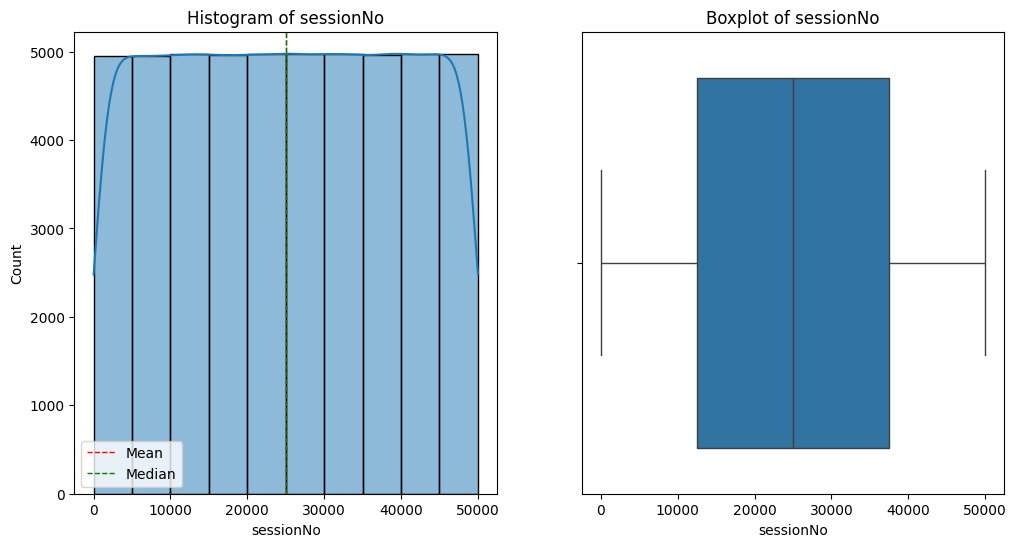

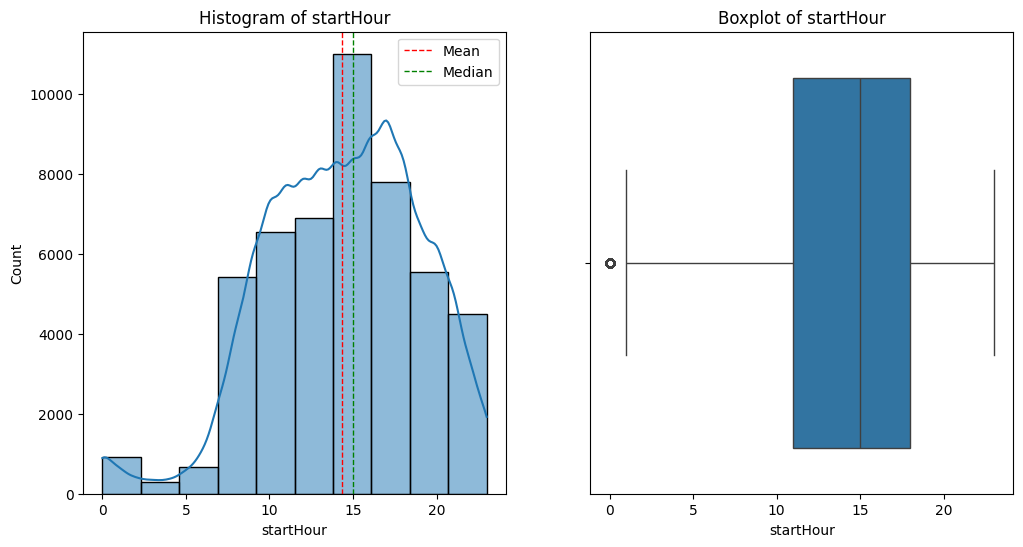

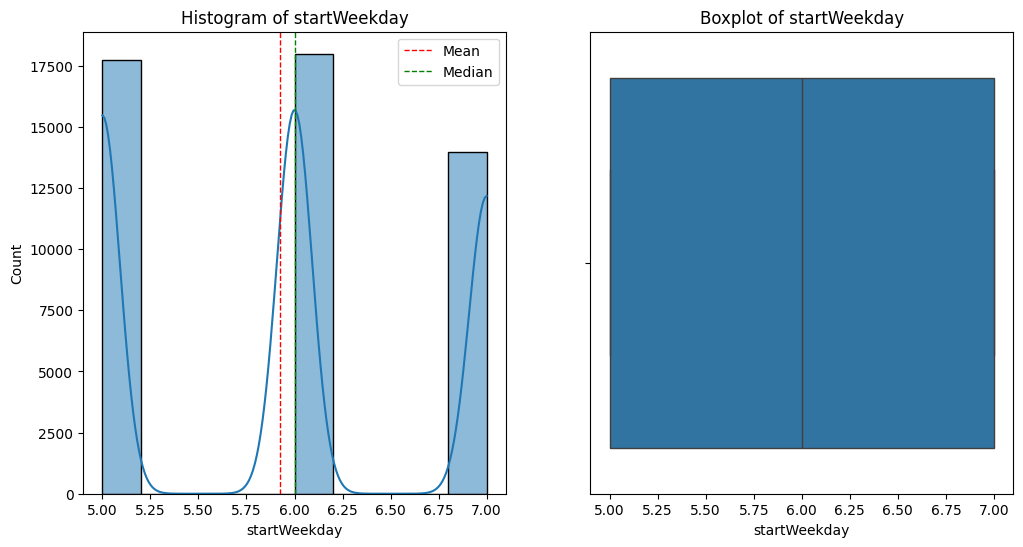

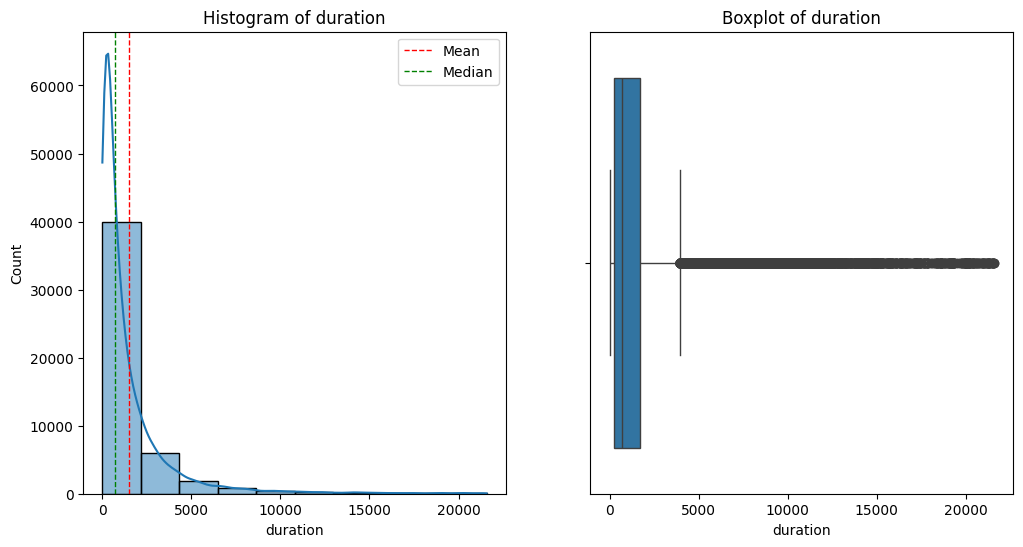

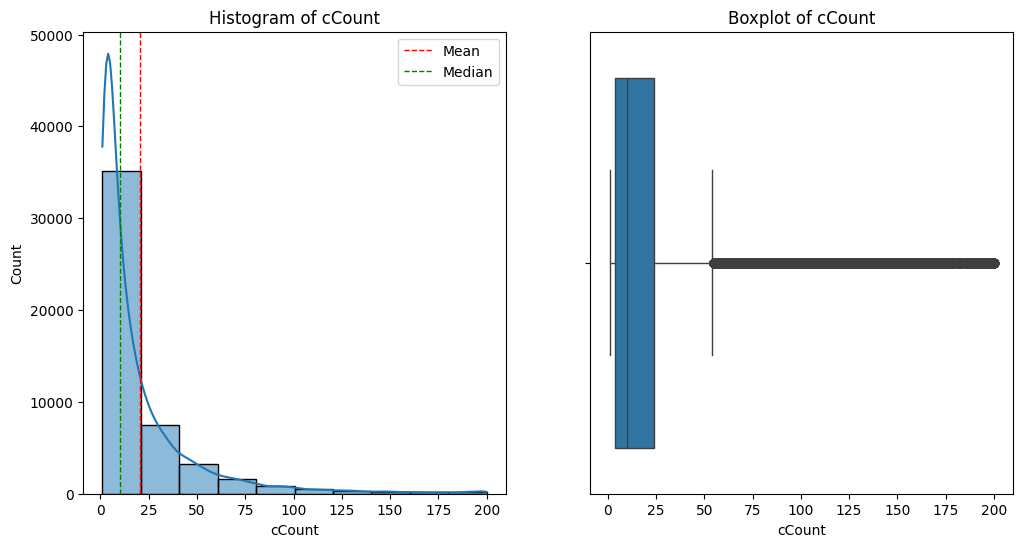

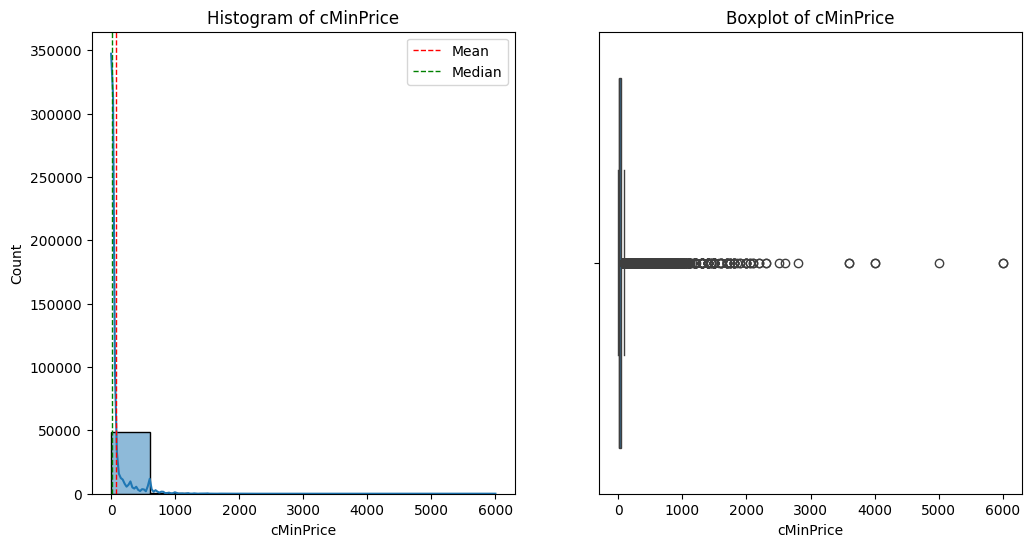

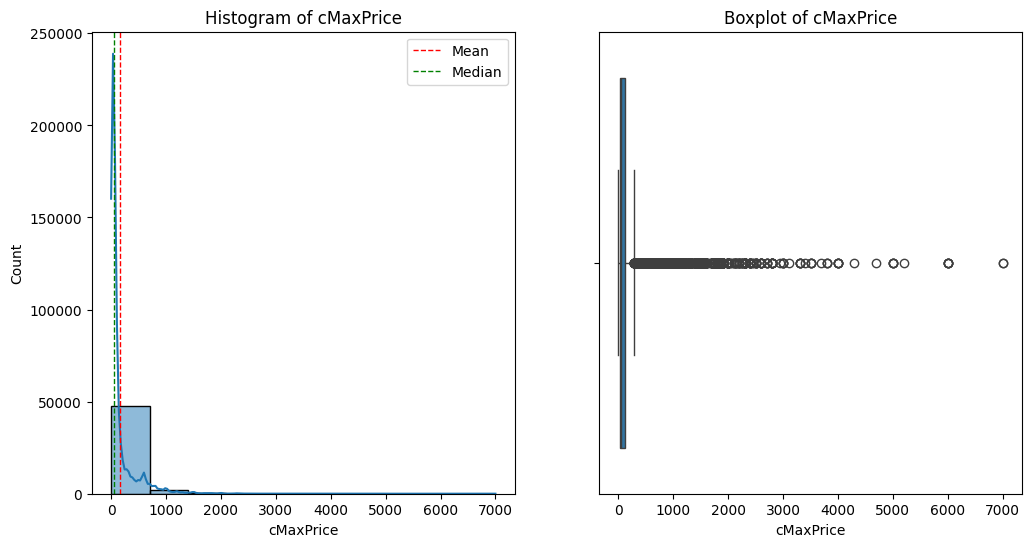

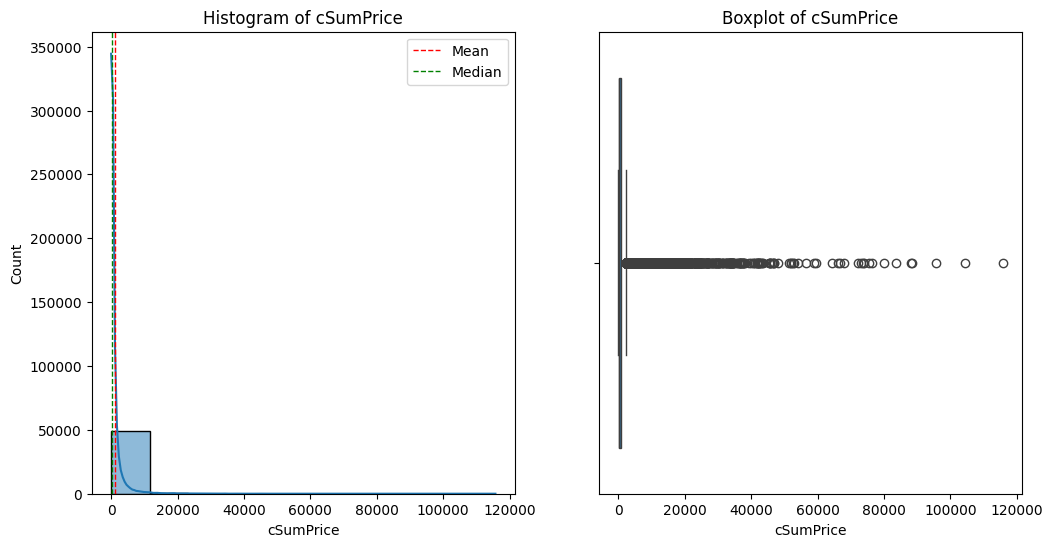

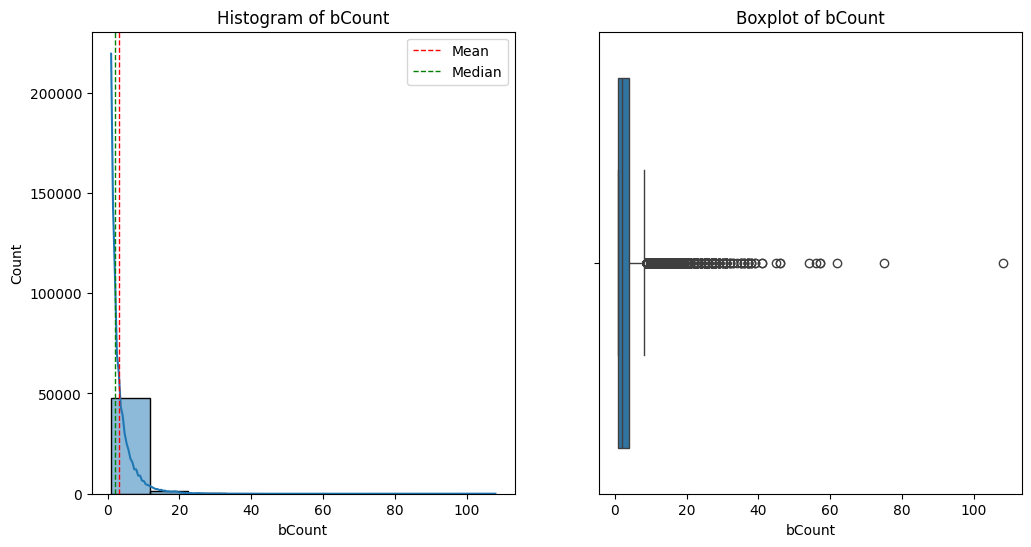

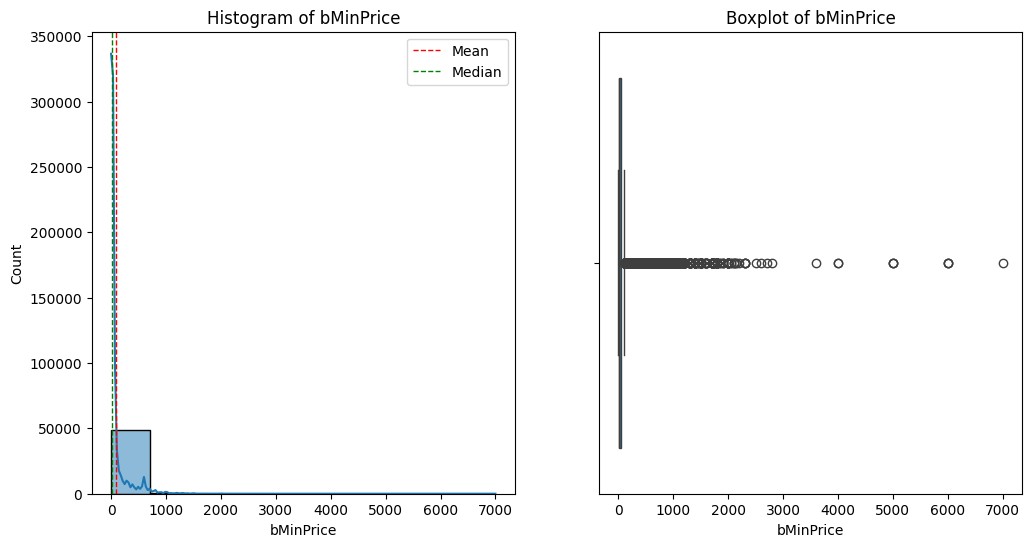

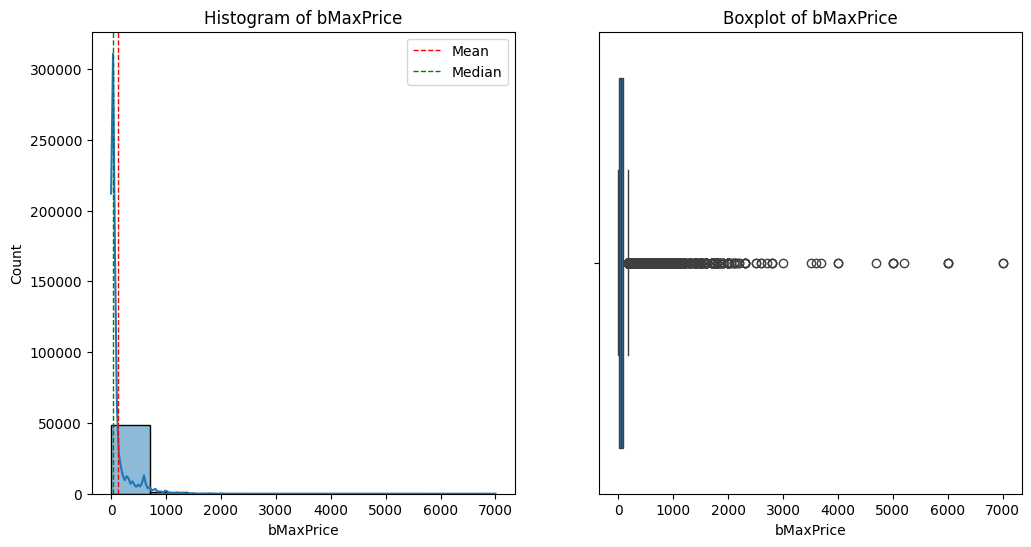

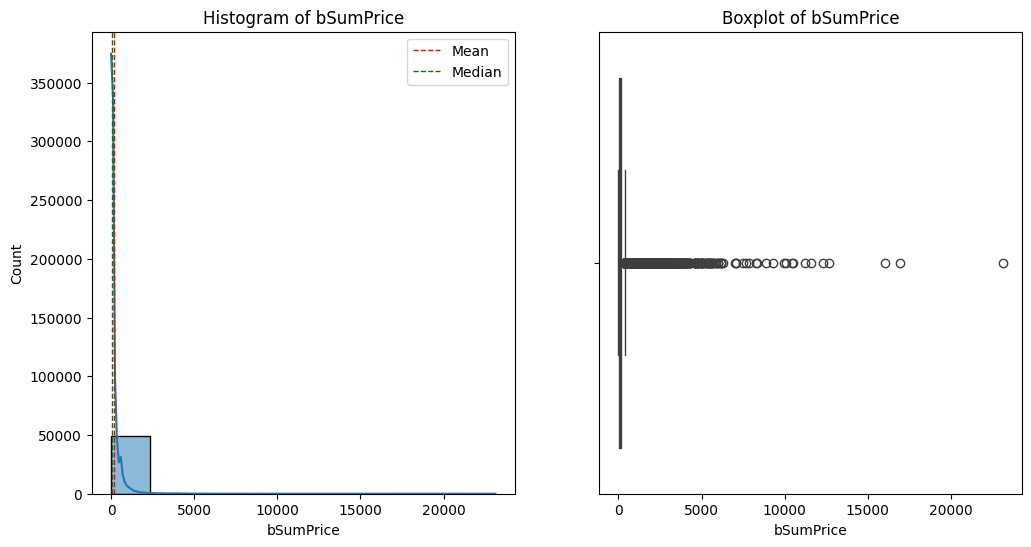

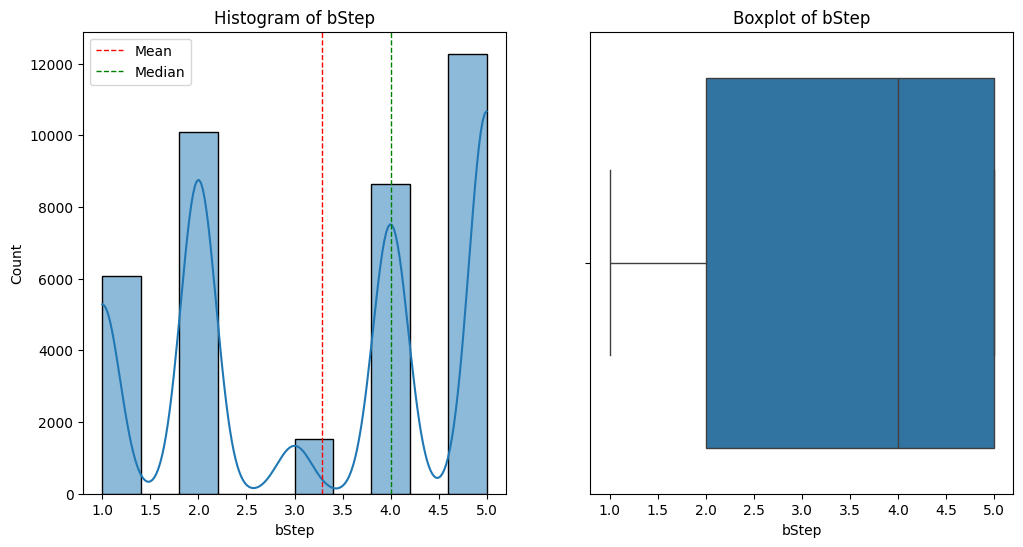

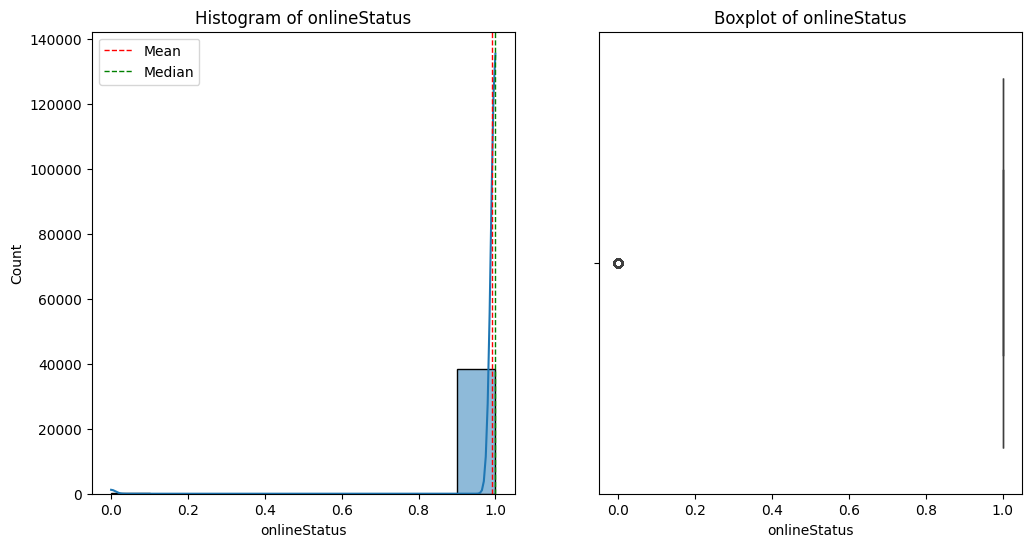

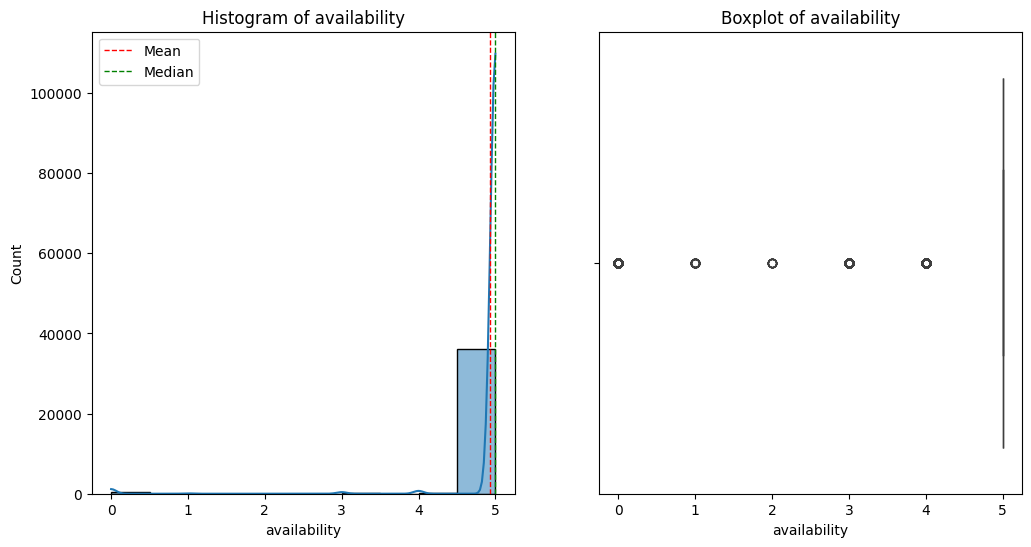

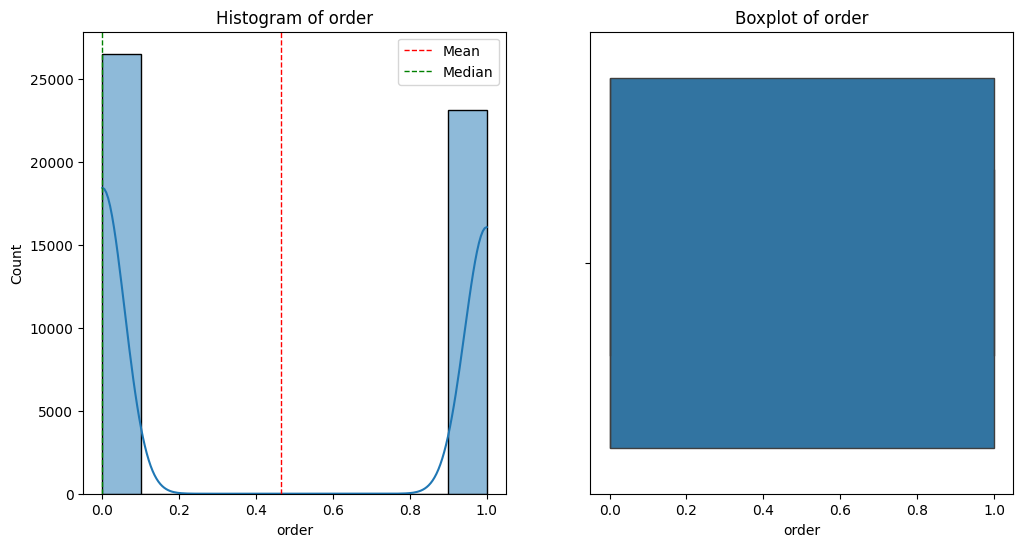

In [945]:
# Langkah 2: Hitung Skewness
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Menyimpan hasil skewness
skewness_results = {column: df[column].skew() for column in numerical_columns}

print("Skewness:")
for feature, skew_value in skewness_results.items():
    print(f"{feature}: {skew_value}")

# Langkah 3: Visualisasi
for column in numerical_columns:
    plt.figure(figsize=(12, 6))
    
    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df[column], bins=10, kde=True)
    plt.title(f'Histogram of {column}')
    plt.axvline(df[column].mean(), color='r', linestyle='dashed', linewidth=1, label='Mean')
    plt.axvline(df[column].median(), color='g', linestyle='dashed', linewidth=1, label='Median')
    plt.legend()
    
    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[column])
    plt.title(f'Boxplot of {column}')
    
    plt.show()

dari plot plot tersebut, terlihat jelas bahwa data memiliki skewness yang sangat tinggi pada mayoritas field numerik, sehingga untuk imputasi terhadap field kategori, kita harus menggunakan data yang telah di transformasi untuk mengurangi skewness tinggi

In [946]:
df_copy = df.copy()

kami menggunakan log transformasi untuk dataset yang telah dicopy

In [947]:
# Terapkan log transformation pada kolom yang relevan
df_copy['log_duration'] = np.log(df_copy['duration'])  # Anggap sudah tidak ada nilai nol
df_copy['log_cCount'] = np.log(df_copy['cCount'])
df_copy['log_cMinPrice'] = np.log(df_copy['cMinPrice'])
df_copy['log_cMaxPrice'] = np.log(df_copy['cMaxPrice'])
df_copy['log_cSumPrice'] = np.log(df_copy['cSumPrice'])
df_copy['log_bCount'] = np.log(df_copy['bCount'])
df_copy['log_bMinPrice'] = np.log(df_copy['bMinPrice'])
df_copy['log_bMaxPrice'] = np.log(df_copy['bMaxPrice'])
df_copy['log_bSumPrice'] = np.log(df_copy['bSumPrice'])

# Tampilkan hasil transformasi
print(df_copy[['duration', 'log_duration', 'cCount', 'log_cCount', 'cMinPrice', 'log_cMinPrice']].head())

    duration  log_duration     cCount  log_cCount  cMinPrice  log_cMinPrice
0     39.887      3.686050   1.000000    0.000000      59.99       4.094178
3     94.469      4.548272   2.689705    0.989432      24.99       3.218476
8    341.613      5.833679  11.000000    2.397895       9.99       2.301585
13    42.812      3.756818   4.000000    1.386294       4.99       1.607436
15  2816.046      7.943089  45.000000    3.806662      12.99       2.564180


lalu memplotkan data copy yang telah ditransformasi

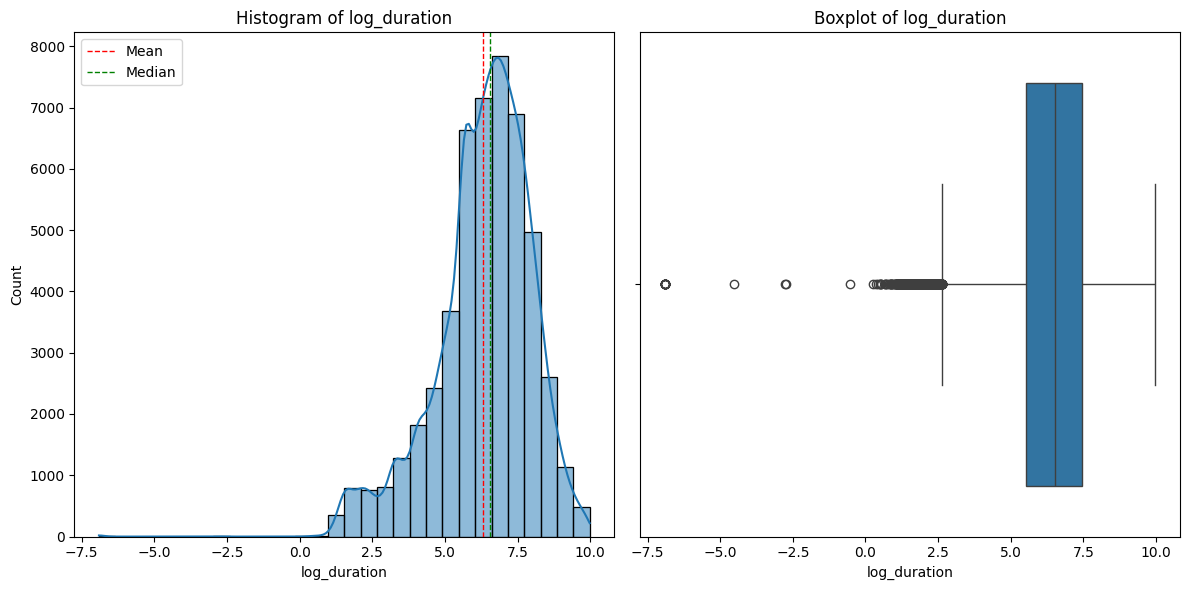

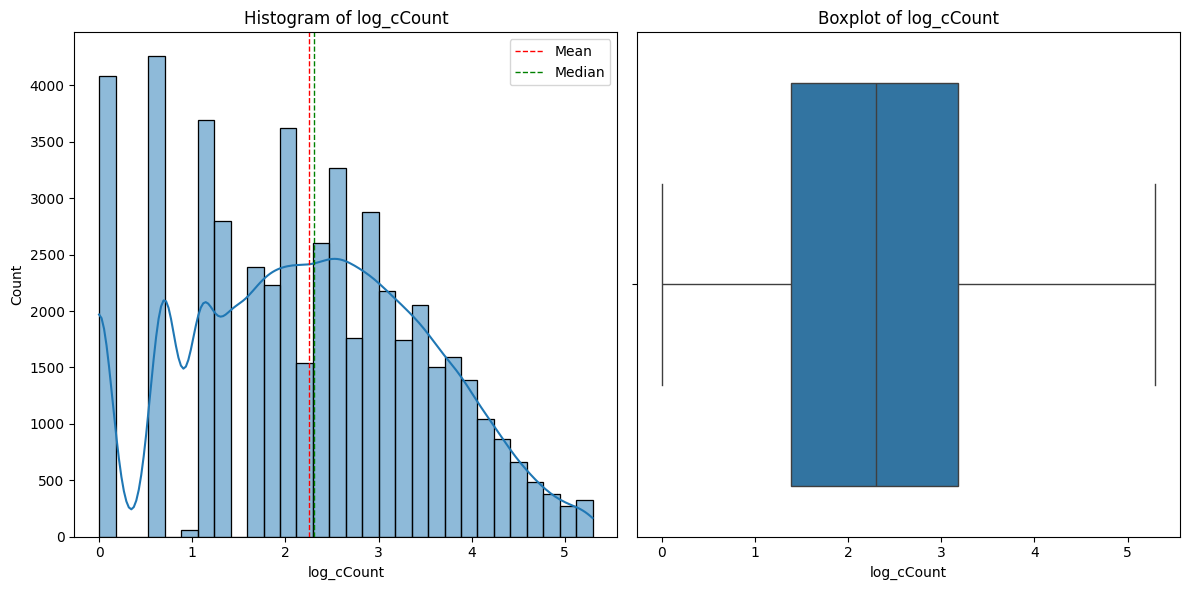

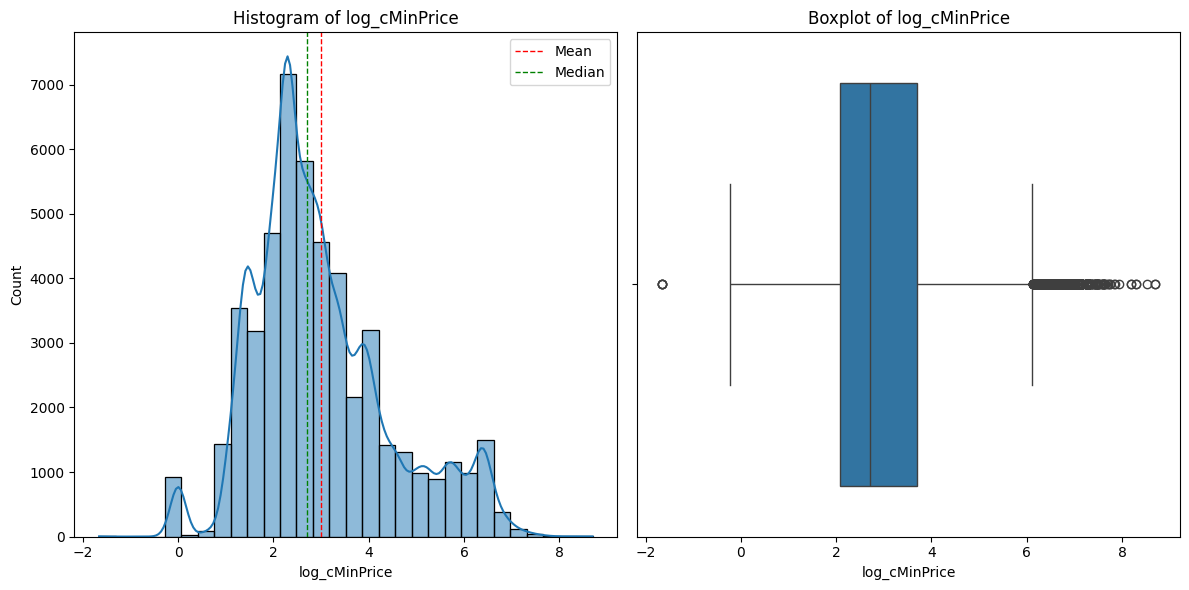

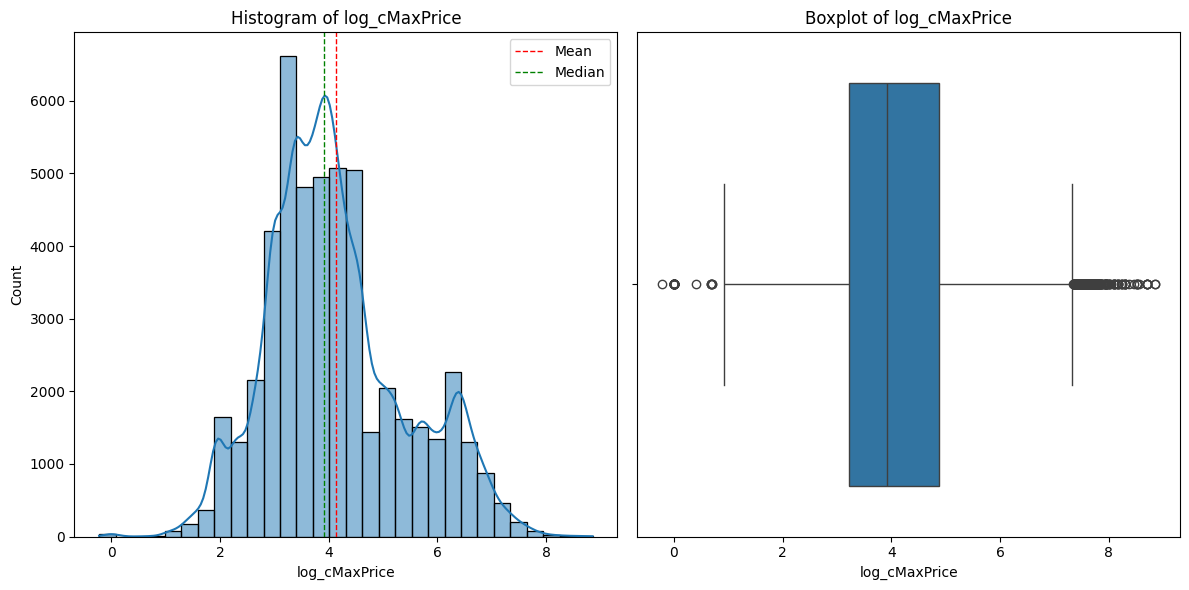

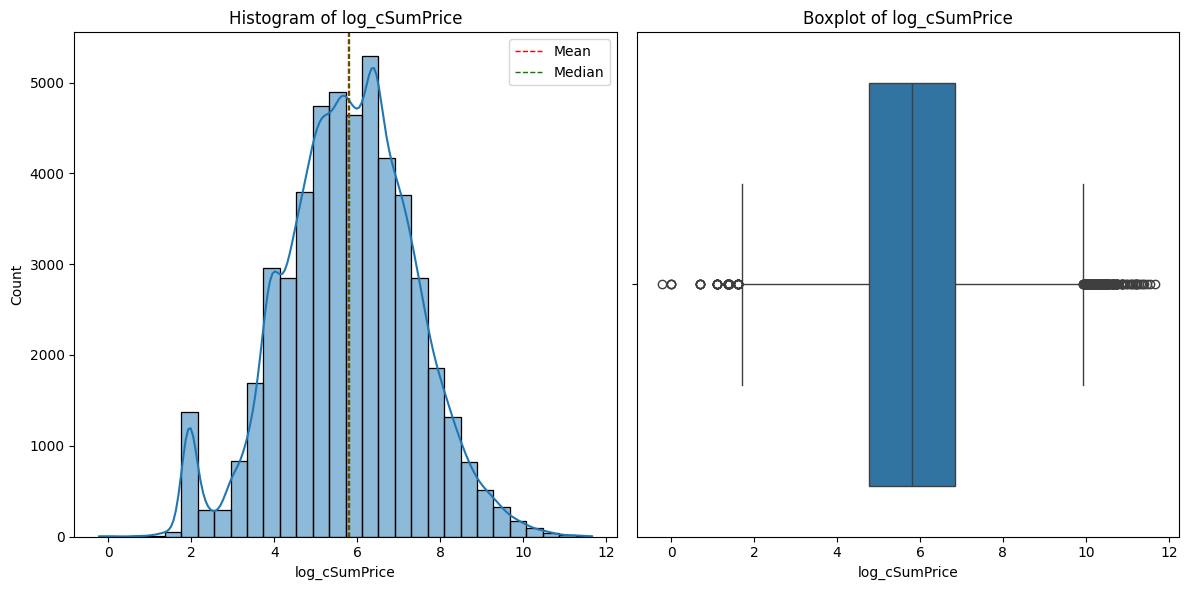

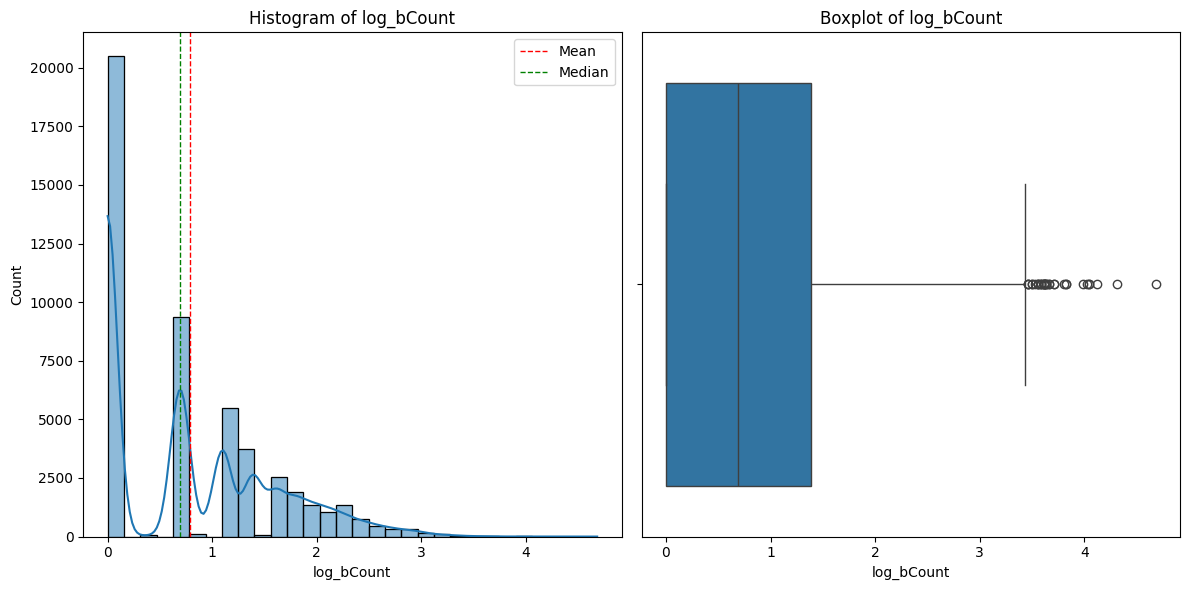

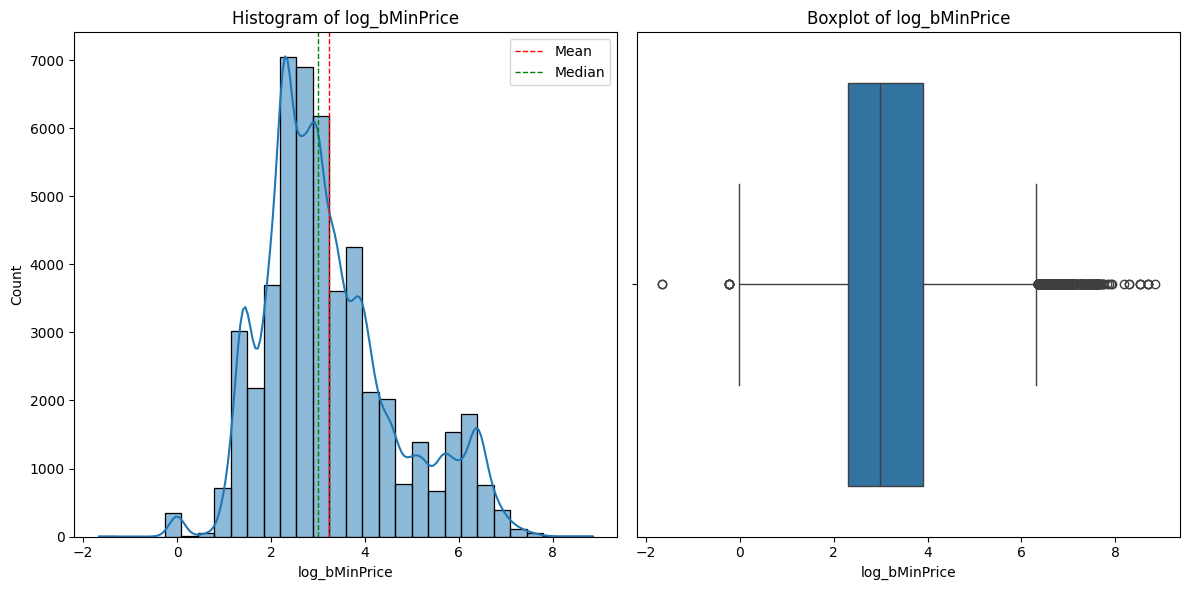

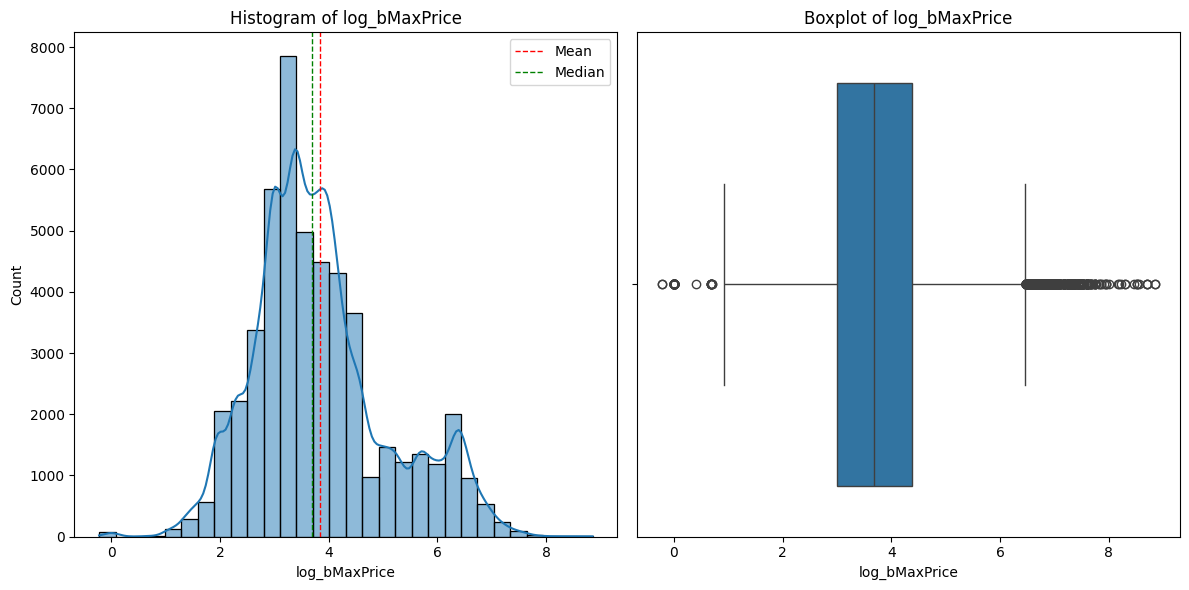

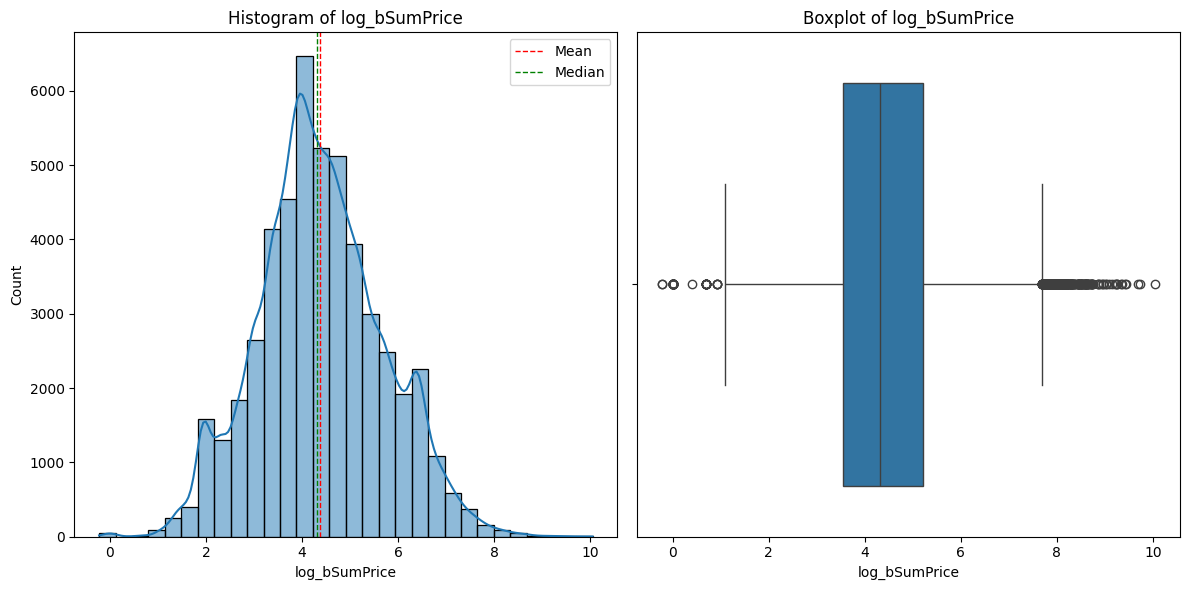

In [948]:
# List of columns to plot
transformed_columns = [
    'log_duration',
    'log_cCount',
    'log_cMinPrice',
    'log_cMaxPrice',
    'log_cSumPrice',
    'log_bCount',
    'log_bMinPrice',
    'log_bMaxPrice',
    'log_bSumPrice'
]

# Function to plot histograms and boxplots for the transformed fields
def plot_transformed_fields(df_copy, columns):
    for column in columns:
        plt.figure(figsize=(12, 6))

        # Histogram
        plt.subplot(1, 2, 1)
        sns.histplot(df_copy[column], bins=30, kde=True)
        plt.title(f'Histogram of {column}')
        plt.axvline(df_copy[column].mean(), color='r', linestyle='dashed', linewidth=1, label='Mean')
        plt.axvline(df_copy[column].median(), color='g', linestyle='dashed', linewidth=1, label='Median')
        plt.legend()

        # Boxplot
        plt.subplot(1, 2, 2)
        sns.boxplot(x=df_copy[column])
        plt.title(f'Boxplot of {column}')

        plt.tight_layout()
        plt.show()

# Call the function to plot the transformed fields
plot_transformed_fields(df_copy, transformed_columns)

sekarang data sudah menjadi lebih balance, dan kami akan melakukan imputasi pada field kategori

### **Imputasi field kategori**

cek jumlah missing value pada field

In [949]:
print(df[['bStep', 'onlineStatus', 'availability']].isnull().sum())

bStep           11035
onlineStatus    10943
availability    12842
dtype: int64


lakukan imputasi menggunakan KNNimputer

In [950]:

imputer = KNNImputer(n_neighbors=5)
df[['bStep', 'onlineStatus', 'availability']] = imputer.fit_transform(df_copy[['bStep', 'onlineStatus', 'availability']])


In [951]:
# Pembulatan pada kolom yang relevan
df['bStep'] = df['bStep'].round()
df['onlineStatus'] = df['onlineStatus'].round()
df['availability'] = df['availability'].round()

# Memeriksa hasil pembulatan
print(df[['bStep', 'onlineStatus', 'availability']].describe())


              bStep  onlineStatus  availability
count  49662.000000  49662.000000  49662.000000
mean       3.239741      0.993134      4.918751
std        1.348003      0.082580      0.499676
min        1.000000      0.000000      0.000000
25%        2.000000      1.000000      5.000000
50%        3.000000      1.000000      5.000000
75%        4.000000      1.000000      5.000000
max        5.000000      1.000000      5.000000


In [952]:
print(df[['bStep', 'onlineStatus', 'availability']].isnull().sum())

bStep           0
onlineStatus    0
availability    0
dtype: int64


## **Train Model**

In [953]:
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
# 2. Memilih semua fitur numerik
numerical_features = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Pastikan 'order' tidak termasuk dalam fitur yang digunakan untuk prediksi
numerical_features.remove('order')  # Pastikan ini sesuai dengan nama kolom yang benar

# 3. Menentukan fitur dan target
X = df[numerical_features]
y = df['order']  # Pastikan ini adalah kolom target yang benar

# 4. Memisahkan data menjadi train dan test untuk validasi
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Membangun dan melatih model Gradient Boosting
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)

# 6. Memprediksi kelas target
y_pred = gb_model.predict(X_test)

# 7. Evaluasi model
accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(class_report)

Accuracy: 0.8574448807006947
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.86      0.87      5307
           1       0.84      0.86      0.85      4626

    accuracy                           0.86      9933
   macro avg       0.86      0.86      0.86      9933
weighted avg       0.86      0.86      0.86      9933



In [990]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# 7. Evaluasi model
accuracy = accuracy_score(y_test, y_pred_rf)
class_report = classification_report(y_test, y_pred_rf)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(class_report)

Accuracy: 0.8612705124333031
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.86      0.87      5307
           1       0.84      0.86      0.85      4626

    accuracy                           0.86      9933
   macro avg       0.86      0.86      0.86      9933
weighted avg       0.86      0.86      0.86      9933



## **Data Analysis**

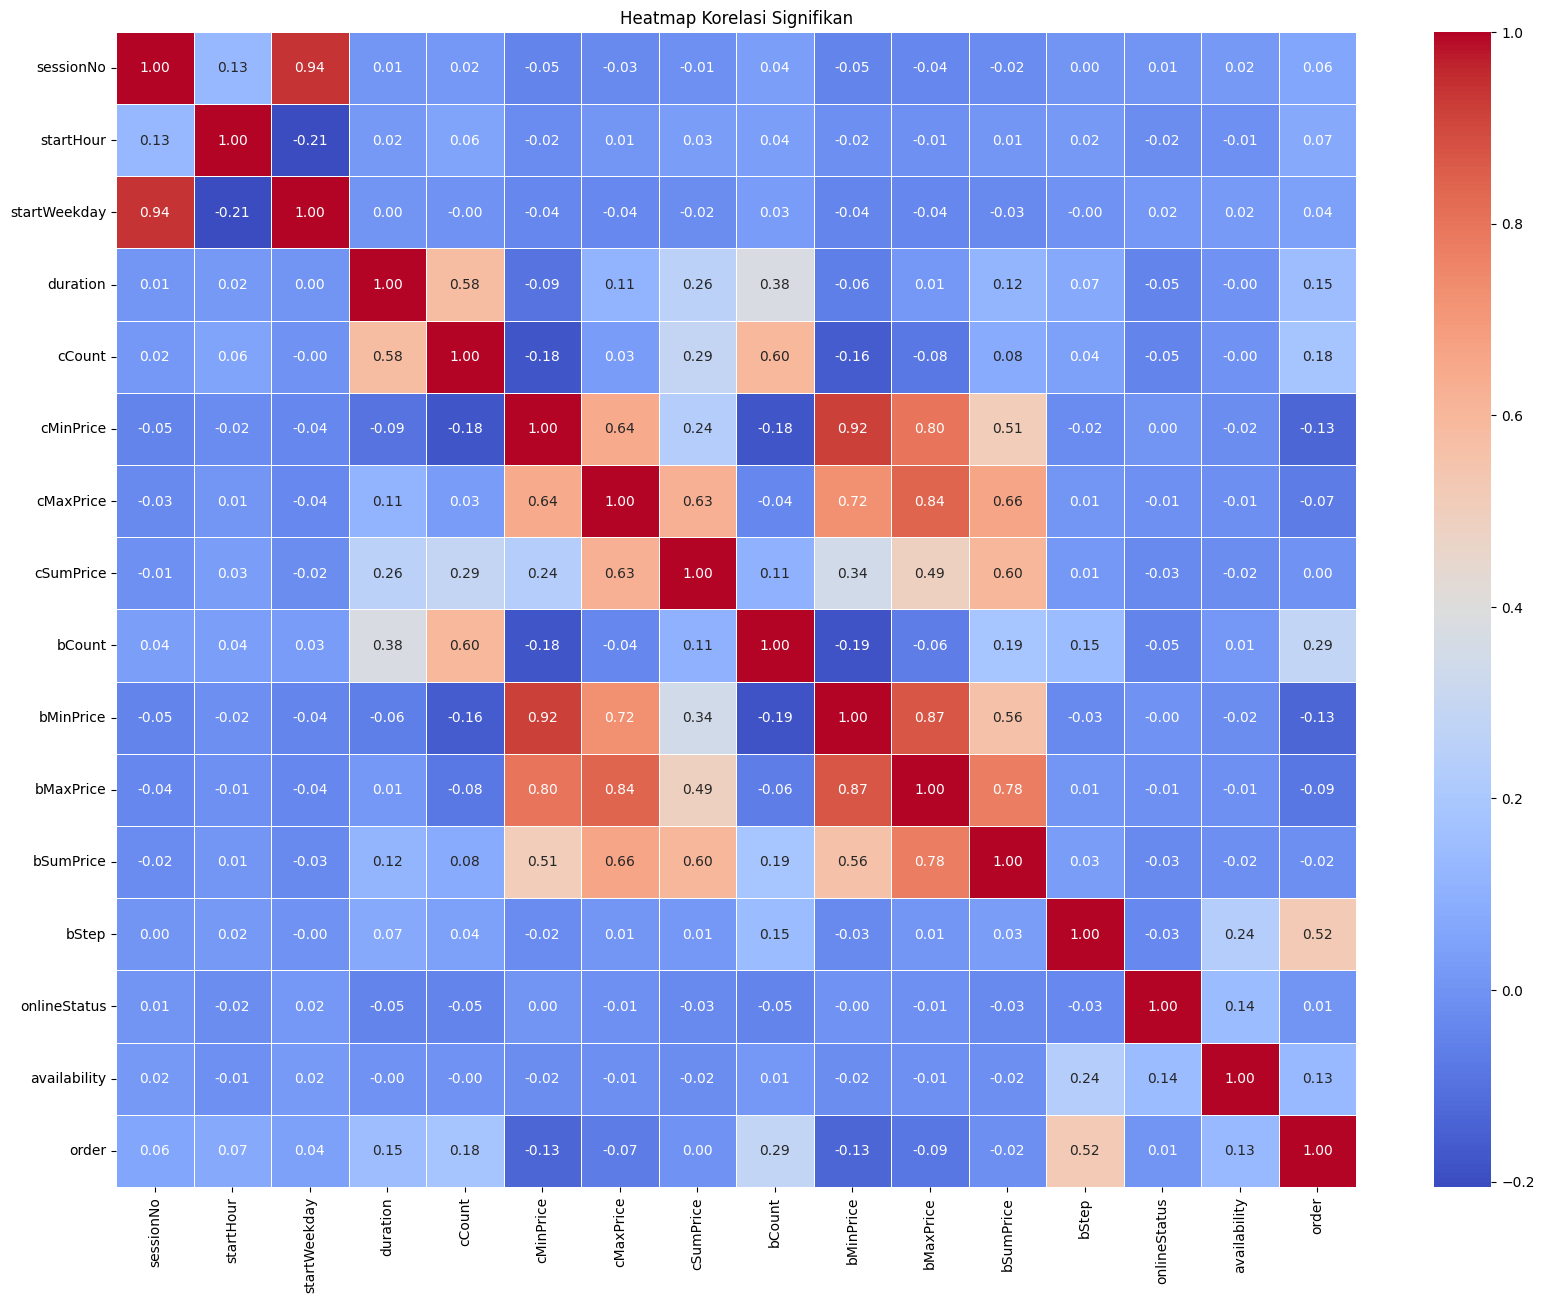

In [955]:
# Membuat mask untuk korelasi rendah
corr_matrix = df.corr()
mask = (corr_matrix < 0.3) & (corr_matrix > -0.3)

# Menampilkan heatmap dengan mask
plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Heatmap Korelasi Signifikan')
plt.show()


* Korelasi Positif yang Kuat:

    cMaxPrice dan cSumPrice memiliki korelasi yang sangat tinggi (0.84). Ini menunjukkan bahwa saat harga maksimum produk yang diklik meningkat, jumlah total harga juga meningkat, yang masuk akal karena produk dengan harga lebih tinggi cenderung memiliki total harga yang lebih tinggi.

    cMinPrice dan cMaxPrice juga menunjukkan korelasi yang tinggi (0.72). Hal ini menunjukkan bahwa harga minimum dan maksimum cenderung bergerak bersama. Ketika harga maksimum meningkat, harga minimum juga cenderung meningkat.

* Korelasi Negatif:

    cCount dan bCount memiliki korelasi positif (0.60), menunjukkan bahwa semakin banyak produk yang diklik, semakin banyak produk yang dimasukkan ke keranjang. Namun, tidak ada korelasi signifikan yang tampak dengan variabel lain.

    bMinPrice menunjukkan korelasi negatif dengan cCount (-0.16), yang mungkin menunjukkan bahwa saat jumlah produk yang diklik meningkat, harga minimum produk di keranjang cenderung lebih rendah.

* Korelasi dengan order:

    order menunjukkan korelasi positif dengan bCount (0.29) dan cCount (0.29), mengindikasikan bahwa lebih banyak produk dalam keranjang atau yang diklik cenderung meningkatkan jumlah pesanan.

    order juga memiliki korelasi negatif dengan onlineStatus (-0.09), yang mungkin menunjukkan bahwa status online tertentu dapat berpengaruh terhadap jumlah pesanan.

* Variabel Lain yang Perlu Diperhatikan:

    duration menunjukkan korelasi positif yang kecil dengan order (0.06). Ini bisa menunjukkan bahwa durasi interaksi berpotensi berkontribusi pada keputusan pembelian, meskipun tidak kuat.

    availability tidak menunjukkan korelasi signifikan dengan variabel lainnya, yang bisa menunjukkan bahwa ketersediaan produk tidak memiliki dampak langsung terhadap pengeluaran atau jumlah pesanan.

* Kesimpulan
    Dari analisis ini, dapat disimpulkan bahwa:

    Variabel harga (minimum dan maksimum) memiliki hubungan yang kuat dengan total harga dan jumlah produk yang diklik.
    Kategori produk yang diklik (cCount) memiliki dampak signifikan terhadap jumlah produk di keranjang (bCount) dan akhirnya pada jumlah pesanan.
    Beberapa variabel, seperti availability, tidak menunjukkan hubungan yang signifikan dalam konteks ini, yang mungkin memerlukan analisis lebih lanjut untuk memahami peran mereka.

# **Klasifikasi kelas target pada transact_class**

## **Load Dataset**

In [1029]:
# Baca file teks ke dalam DataFrame
file_path = 'https://raw.githubusercontent.com/Schnee111/Classification-kel7/refs/heads/main/transact_class.txt'  # Ganti dengan nama file Anda
pred = pd.read_csv(file_path, sep='|', header=0, na_values='?')  # `header=0` untuk membaca header dari baris pertama


# Tampilkan beberapa baris pertama untuk memastikan data diimpor dengan benar
pred.head()

,sessionNo,startHour,startWeekday,duration,cCount,cMinPrice,cMaxPrice,cSumPrice,bCount,bMinPrice,...,onlineStatus,availability,customerNo,maxVal,customerScore,accountLifetime,payments,age,address,lastOrder
0,1,18,7,136.833,3,39.99,39.99,79.98,1,39.99,...,y,completely orderable,25039.0,1300.0,489.0,188.0,5.0,49.0,1.0,65.0
1,1,18,7,189.984,3,39.99,39.99,79.98,1,39.99,...,y,completely orderable,25039.0,1300.0,489.0,188.0,5.0,49.0,1.0,65.0
2,1,18,7,342.894,6,16.99,39.99,113.96,2,16.99,...,NaN,NaN,25039.0,1300.0,489.0,188.0,5.0,49.0,1.0,65.0
3,1,18,7,411.051,8,16.99,39.99,149.94,3,16.99,...,NaN,NaN,25039.0,1300.0,489.0,188.0,5.0,49.0,1.0,65.0
4,1,18,7,460.049,10,16.99,39.99,189.92,4,16.99,...,NaN,NaN,25039.0,1300.0,489.0,188.0,5.0,49.0,1.0,65.0


In [1030]:
realclass = pd.read_csv("https://raw.githubusercontent.com/Schnee111/Classification-kel7/refs/heads/main/realclass_t1.txt", sep='|', header=0)
realclass.head()

,sessionNo,prediction
0,1,1
1,2,1
2,3,1
3,4,0
4,5,0


## **Praprocess**

proses yang dilakukan pada dataset ini kami buat serupa dengan penanganan dataset training tadi

### **Drop field**

In [1031]:
# Menghapus kolom yang dianggap kurang penting atau terlalu banyak missing values
cols_to_drop = ['maxVal', 'accountLifetime', 'customerScore',
                 'payments', 'customerNo', 'age', 'address', 'lastOrder']
pred.drop(columns=cols_to_drop, inplace=True)

### **Konversi categorical field ke numeric**

In [1032]:
# Mengonversi kolom 'order' menjadi numerik

pred['onlineStatus'] = pred['onlineStatus'].map({'y': 1, 'n': 0})

pred['availability'] = pred['availability'].map({'completely not orderable': 0, 'mainly not orderable': 1, 'mainly not determinable': 2, 
                                             'mixed' : 3, 'mainly orderable': 4, 'completely orderable': 5})

### **Cek missing values**

In [1033]:
print("Jumlah missing values per kolom:")
print(pred.isnull().sum())

Jumlah missing values per kolom:
sessionNo           0
startHour           0
startWeekday        0
duration            0
cCount              0
cMinPrice         326
cMaxPrice         326
cSumPrice         326
bCount              0
bMinPrice         589
bMaxPrice         589
bSumPrice         589
bStep           20766
onlineStatus    17355
availability    17847
dtype: int64


### **Cek zero values**

In [1034]:
numerical_features = ['duration', 'cCount', 'cMinPrice', 'cMaxPrice', 'cSumPrice', 'bCount', 'bMinPrice', 'bMaxPrice', 'bSumPrice']
zero_values = (pred[numerical_features] == 0).sum()
zero_values = zero_values[zero_values > 0]
print("Kolom dengan zero values dan jumlahnya:")
print(zero_values)

Kolom dengan zero values dan jumlahnya:
duration     2164
cCount        142
cMinPrice     461
cMaxPrice       1
cSumPrice       1
bCount        367
bMinPrice     277
bMaxPrice       3
bSumPrice       3
dtype: int64


### **Field duration**

In [1035]:
print(len(pred[(pred['duration'] == 0)]))
pred[(pred['duration'] == 0)].head(20)

2164


,sessionNo,startHour,startWeekday,duration,cCount,cMinPrice,cMaxPrice,cSumPrice,bCount,bMinPrice,bMaxPrice,bSumPrice,bStep,onlineStatus,availability
54,7,18,7,0.0,1,14.99,14.99,14.99,1,14.99,14.99,14.99,NaN,NaN,NaN
188,18,18,7,0.0,1,59.95,59.95,59.95,1,59.95,59.95,59.95,NaN,NaN,NaN
189,18,18,7,0.0,2,59.95,59.95,119.90,2,59.95,59.95,119.90,NaN,NaN,NaN
190,18,18,7,0.0,3,19.99,59.95,139.89,3,19.99,59.95,139.89,NaN,NaN,NaN
265,28,18,7,0.0,1,49.99,49.99,49.99,1,49.99,49.99,49.99,NaN,NaN,NaN
392,39,18,7,0.0,1,17.99,17.99,17.99,1,17.99,17.99,17.99,NaN,NaN,NaN
432,43,18,7,0.0,1,49.99,49.99,49.99,1,49.99,49.99,49.99,NaN,NaN,NaN
452,46,18,7,0.0,1,17.95,17.95,17.95,1,17.95,17.95,17.95,NaN,NaN,NaN
453,46,18,7,0.0,2,17.95,19.99,37.94,2,17.95,19.99,37.94,NaN,NaN,NaN
478,48,18,7,0.0,1,39.99,39.99,39.99,1,39.99,39.99,39.99,NaN,NaN,NaN


In [1036]:
pred[(pred['duration'] == 0)].tail(20)

,sessionNo,startHour,startWeekday,duration,cCount,cMinPrice,cMaxPrice,cSumPrice,bCount,bMinPrice,bMaxPrice,bSumPrice,bStep,onlineStatus,availability
44933,5081,5,1,0.0,3,99.99,169.00,398.98,3,99.99,169.00,398.98,NaN,NaN,NaN
44934,5082,5,1,0.0,1,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN
44954,5085,5,1,0.0,1,49.99,49.99,49.99,1,49.99,49.99,49.99,NaN,NaN,NaN
44970,5088,5,1,0.0,1,49.99,49.99,49.99,1,49.99,49.99,49.99,NaN,NaN,NaN
44972,5089,5,1,0.0,1,49.99,49.99,49.99,1,49.99,49.99,49.99,NaN,NaN,NaN
44974,5091,5,1,0.0,1,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN
44988,5093,5,1,0.0,1,99.99,99.99,99.99,1,99.99,99.99,99.99,NaN,NaN,NaN
44989,5093,5,1,0.0,2,99.99,169.00,268.99,2,99.99,169.00,268.99,NaN,NaN,NaN
44990,5093,5,1,0.0,3,99.99,169.00,398.98,3,99.99,169.00,398.98,NaN,NaN,NaN
45003,5095,5,1,0.0,1,6.99,6.99,6.99,1,6.99,6.99,6.99,NaN,NaN,NaN


kasus ini sama dengan dataset train tadi, maka kami akan mengimputasi dengan cara yang sama juga

In [1037]:
pred['cCount'].describe()

count    45068.000000
mean        27.316810
std         32.549188
min          0.000000
25%          6.000000
50%         15.000000
75%         36.000000
max        200.000000
Name: cCount, dtype: float64

In [1038]:
bins = [0, 4, 10, 24, 200]  # Rentang yang diusulkan
labels = ['Very Low', 'Low', 'Medium', 'High']

# Mengklasifikasikan nilai cCount
pred['count_class'] = pd.cut(pred['cCount'], bins=bins, labels=labels, right=True)

# Menghitung rata-rata durasi berdasarkan kelas count
durasi_by_count_class = pred.groupby('count_class')['duration'].mean().reset_index()

# Menampilkan hasil
print(durasi_by_count_class)

  count_class     duration
0    Very Low   239.270529
1         Low   642.500282
2      Medium  1300.993100
3        High  3217.974723


In [1039]:
# Mengisi nilai durasi yang nol dengan rata-rata berdasarkan kelas count
for count_class in pred['count_class'].unique():
    mean_duration = pred.loc[pred['count_class'] == count_class, 'duration'].mean()
    pred.loc[(pred['duration'] == 0) & (pred['count_class'] == count_class), 'duration'] = mean_duration


In [1040]:
print(len(pred[(pred['duration'] == 0)]))

26


In [1041]:
pred.drop(columns=['count_class'], inplace=True)

### **Imputasi field numerik**

In [1042]:
# Transformasi log dan mengkategorikan berdasarkan log
pred['log_duration'] = np.log1p(pred['duration'])
pred['kategori_durasi'] = pd.cut(pred['log_duration'], bins=4, labels=['sangat_pendek', 'pendek', 'sedang', 'panjang'])

# Menghitung nilai median untuk setiap kategori durasi
impute_values = pred.groupby('kategori_durasi')[['cCount', 'cMinPrice', 'cMaxPrice', 'cSumPrice', 
                                               'bCount', 'bMinPrice', 'bMaxPrice', 'bSumPrice']].transform('median')

# Mengisi nilai yang hilang berdasarkan kategori durasi
pred[['cCount', 'cMinPrice', 'cMaxPrice', 'cSumPrice', 
    'bCount', 'bMinPrice', 'bMaxPrice', 'bSumPrice']] = pred[['cCount', 'cMinPrice', 'cMaxPrice', 'cSumPrice', 
                                                            'bCount', 'bMinPrice', 'bMaxPrice', 'bSumPrice']].fillna(impute_values)

# Menghapus kolom bantu
pred.drop(columns=['kategori_durasi', 'log_duration'], inplace=True)

In [1043]:
print("\nJumlah missing values per kolom setelah proses:")
print(pred.isnull().sum())


Jumlah missing values per kolom setelah proses:
sessionNo           0
startHour           0
startWeekday        0
duration            0
cCount              0
cMinPrice           0
cMaxPrice           0
cSumPrice           0
bCount              0
bMinPrice           0
bMaxPrice           0
bSumPrice           0
bStep           20766
onlineStatus    17355
availability    17847
dtype: int64


### **Imputasi cMin dengan bMin**

In [1044]:
numerical_features = ['duration', 'cCount', 'cMinPrice', 'cMaxPrice', 'cSumPrice', 'bCount', 'bMinPrice', 'bMaxPrice', 'bSumPrice']
zero_values = (pred[numerical_features] == 0).sum()
zero_values = zero_values[zero_values > 0]
print("Kolom dengan zero values dan jumlahnya:")
print(zero_values)

Kolom dengan zero values dan jumlahnya:
duration      26
cCount       142
cMinPrice    461
cMaxPrice      1
cSumPrice      1
bCount       367
bMinPrice    277
bMaxPrice      3
bSumPrice      3
dtype: int64


In [1045]:
# Mengganti nilai 0 di cMinPrice dengan nilai dari bMinPrice
pred.loc[pred['cMinPrice'] == 0, 'cMinPrice'] = pred['bMinPrice']

In [1046]:
numerical_features = ['duration', 'cCount', 'cMinPrice', 'cMaxPrice', 'cSumPrice', 'bCount', 'bMinPrice', 'bMaxPrice', 'bSumPrice']
zero_values = (pred[numerical_features] == 0).sum()
zero_values = zero_values[zero_values > 0]
print("Kolom dengan zero values dan jumlahnya:")
print(zero_values)

Kolom dengan zero values dan jumlahnya:
duration      26
cCount       142
cMinPrice    277
cMaxPrice      1
cSumPrice      1
bCount       367
bMinPrice    277
bMaxPrice      3
bSumPrice      3
dtype: int64


### **Imputasi cMin dan bMin sisa**

In [1047]:
# Menghitung median global untuk cMinPrice dan bMinPrice
global_median_cMinPrice = pred['cMinPrice'].median()
global_median_bMinPrice = pred['bMinPrice'].median()

# Imputasi cMinPrice dengan kondisi
pred['cMinPrice'] = pred.apply(
    lambda row: min(global_median_cMinPrice, row['cMaxPrice']) if row['cMinPrice'] == 0 else row['cMinPrice'],
    axis=1
)

# Imputasi bMinPrice dengan kondisi
pred['bMinPrice'] = pred.apply(
    lambda row: min(global_median_bMinPrice, row['bMaxPrice']) if row['bMinPrice'] == 0 else row['bMinPrice'],
    axis=1
)


In [1048]:
numerical_features = ['duration', 'cCount', 'cMinPrice', 'cMaxPrice', 'cSumPrice', 'bCount', 'bMinPrice', 'bMaxPrice', 'bSumPrice']
zero_values = (pred[numerical_features] == 0).sum()
zero_values = zero_values[zero_values > 0]
print("Kolom dengan zero values dan jumlahnya:")
print(zero_values)

Kolom dengan zero values dan jumlahnya:
duration      26
cCount       142
cMinPrice      1
cMaxPrice      1
cSumPrice      1
bCount       367
bMinPrice      3
bMaxPrice      3
bSumPrice      3
dtype: int64


### **Imputasi count**

In [1049]:
# Menghitung estimasi cCount menggunakan cMinPrice dan cMaxPrice
pred['cCount'] = pred.apply(lambda row: 
                        row['cSumPrice'] / ((row['cMinPrice'] + row['cMaxPrice']) / 2) 
                        if row['cCount'] == 0 and row['cMinPrice'] > 0 and row['cMaxPrice'] > row['cMinPrice'] 
                        else row['cSumPrice'] / row['cMinPrice'] 
                        if row['cCount'] == 0 and row['cMinPrice'] > 0 
                        else row['cCount'], 
                        axis=1)

# Menghitung estimasi bCount menggunakan bMinPrice dan bMaxPrice
pred['bCount'] = pred.apply(lambda row: 
                        row['bSumPrice'] / ((row['bMinPrice'] + row['bMaxPrice']) / 2) 
                        if row['bCount'] == 0 and row['bMinPrice'] > 0 and row['bMaxPrice'] > row['bMinPrice'] 
                        else row['bSumPrice'] / row['bMinPrice'] 
                        if row['bCount'] == 0 and row['bMinPrice'] > 0 
                        else row['bCount'], 
                        axis=1)

In [1050]:
numerical_features = ['duration', 'cCount', 'cMinPrice', 'cMaxPrice', 'cSumPrice', 'bCount', 'bMinPrice', 'bMaxPrice', 'bSumPrice']
zero_values = (pred[numerical_features] == 0).sum()
zero_values = zero_values[zero_values > 0]
print("Kolom dengan zero values dan jumlahnya:")        
print(zero_values)

Kolom dengan zero values dan jumlahnya:
duration     26
cMinPrice     1
cMaxPrice     1
cSumPrice     1
bMinPrice     3
bMaxPrice     3
bSumPrice     3
dtype: int64


### **Imputasi sisa data duration**

In [1051]:
bins = [0, 4, 10, 24, 200]  # Rentang yang diusulkan
labels = ['Very Low', 'Low', 'Medium', 'High']

# Mengklasifikasikan nilai cCount
pred['count_class'] = pd.cut(pred['cCount'], bins=bins, labels=labels, right=True)

# Menghitung rata-rata durasi berdasarkan kelas count
durasi_by_count_class = pred.groupby('count_class')['duration'].mean().reset_index()

# Menampilkan hasil
print(durasi_by_count_class)

  count_class     duration
0    Very Low   280.129807
1         Low   667.206192
2      Medium  1312.442398
3        High  3217.974723


In [1052]:
# Mengisi nilai durasi yang nol dengan rata-rata berdasarkan kelas count
for count_class in pred['count_class'].unique():
    mean_duration = pred.loc[pred['count_class'] == count_class, 'duration'].mean()
    pred.loc[(pred['duration'] == 0) & (pred['count_class'] == count_class), 'duration'] = mean_duration


In [1053]:
pred.drop(columns=['count_class'], inplace=True)

In [1054]:
numerical_features = ['duration', 'cCount', 'cMinPrice', 'cMaxPrice', 'cSumPrice', 'bCount', 'bMinPrice', 'bMaxPrice', 'bSumPrice']
zero_values = (pred[numerical_features] == 0).sum()
# Menyaring kolom dengan jumlah nol lebih dari 0
zero_columns = zero_values[zero_values > 0].index.tolist()

# Menampilkan data yang memiliki nilai nol di kolom yang teridentifikasi
zero_data = pred[pred[zero_columns].eq(0).any(axis=1)]

# Menampilkan hasil
print("Data dengan nilai nol pada kolom-kolom berikut:")
zero_data.head(10)

Data dengan nilai nol pada kolom-kolom berikut:


,sessionNo,startHour,startWeekday,duration,cCount,cMinPrice,cMaxPrice,cSumPrice,bCount,bMinPrice,bMaxPrice,bSumPrice,bStep,onlineStatus,availability
15406,1591,20,7,485.483,3.0,9.99,299.99,299.99,1.0,0.0,0.0,0.0,NaN,NaN,NaN
16397,1715,20,7,88.553,3.0,4.99,4.99,4.99,1.0,0.0,0.0,0.0,NaN,NaN,NaN
18723,1942,20,7,11.909,2.0,0.00,0.00,0.00,1.0,0.0,0.0,0.0,NaN,NaN,NaN


### **Imputasi sisa data numerik lainnya**

In [1055]:
# Mengisi bMinPrice, bMaxPrice, dan bSumPrice berdasarkan rata-rata dari cMinPrice dan cMaxPrice
for index, row in pred.iterrows():
    if row['bMinPrice'] == 0:
        pred.at[index, 'bMinPrice'] = (row['cMinPrice'] + row['cMaxPrice']) / 2
    if row['bMaxPrice'] == 0:
        pred.at[index, 'bMaxPrice'] = (row['cMinPrice'] + row['cMaxPrice']) / 2
    if row['bSumPrice'] == 0:
        pred.at[index, 'bSumPrice'] = (row['bMinPrice'] + row['bMaxPrice']) / 2

In [1056]:
numerical_features = ['duration', 'cCount', 'cMinPrice', 'cMaxPrice', 'cSumPrice', 'bCount', 'bMinPrice', 'bMaxPrice', 'bSumPrice']
zero_values = (pred[numerical_features] == 0).sum()
# Menyaring kolom dengan jumlah nol lebih dari 0
zero_columns = zero_values[zero_values > 0].index.tolist()

# Menampilkan data yang memiliki nilai nol di kolom yang teridentifikasi
zero_data = pred[pred[zero_columns].eq(0).any(axis=1)]

# Menampilkan hasil
print("Data dengan nilai nol pada kolom-kolom berikut:")
zero_data.head(10)

Data dengan nilai nol pada kolom-kolom berikut:


,sessionNo,startHour,startWeekday,duration,cCount,cMinPrice,cMaxPrice,cSumPrice,bCount,bMinPrice,bMaxPrice,bSumPrice,bStep,onlineStatus,availability
15406,1591,20,7,485.483,3.0,9.99,299.99,299.99,1.0,154.99,154.99,0.0,NaN,NaN,NaN
16397,1715,20,7,88.553,3.0,4.99,4.99,4.99,1.0,4.99,4.99,0.0,NaN,NaN,NaN
18723,1942,20,7,11.909,2.0,0.00,0.00,0.00,1.0,0.00,0.00,0.0,NaN,NaN,NaN


### **Imputasi field kategori**

imputasi di field kategori juga sama, kami akan mengcopy dataset untuk transformasi, dan menggunakan KNNimputer untuk imputasi

In [1057]:
pred_copy = pred.copy()

In [1058]:
# Terapkan log transformation pada kolom yang relevan
df_copy['log_duration'] = np.log(df_copy['duration'])  # Anggap sudah tidak ada nilai nol
df_copy['log_cCount'] = np.log(df_copy['cCount'])
df_copy['log_cMinPrice'] = np.log(df_copy['cMinPrice'])
df_copy['log_cMaxPrice'] = np.log(df_copy['cMaxPrice'])
df_copy['log_cSumPrice'] = np.log(df_copy['cSumPrice'])
df_copy['log_bCount'] = np.log(df_copy['bCount'])
df_copy['log_bMinPrice'] = np.log(df_copy['bMinPrice'])
df_copy['log_bMaxPrice'] = np.log(df_copy['bMaxPrice'])
df_copy['log_bSumPrice'] = np.log(df_copy['bSumPrice'])

# Tampilkan hasil transformasi
print(df_copy[['duration', 'log_duration', 'cCount', 'log_cCount', 'cMinPrice', 'log_cMinPrice']].head())

    duration  log_duration     cCount  log_cCount  cMinPrice  log_cMinPrice
0     39.887      3.686050   1.000000    0.000000      59.99       4.094178
3     94.469      4.548272   2.689705    0.989432      24.99       3.218476
8    341.613      5.833679  11.000000    2.397895       9.99       2.301585
13    42.812      3.756818   4.000000    1.386294       4.99       1.607436
15  2816.046      7.943089  45.000000    3.806662      12.99       2.564180


In [1059]:

imputer = KNNImputer(n_neighbors=5)
pred[['bStep', 'onlineStatus', 'availability']] = imputer.fit_transform(pred_copy[['bStep', 'onlineStatus', 'availability']])


In [1060]:
print(df[['bStep', 'onlineStatus', 'availability']].isnull().sum())

bStep           0
onlineStatus    0
availability    0
dtype: int64


## **Aplikasi model prediksi pada data class**

In [1061]:
pred_rf = pred.copy()
pred_cb = pred.copy()

### **Gradient Boost**

In [1062]:
# 1. Memastikan bahwa fitur dalam pred sama dengan fitur yang digunakan untuk melatih model
# Memilih semua fitur numerik dari pred
pred_features = pred.select_dtypes(include=['float64', 'int64']).columns.tolist()

# 2. Menggunakan model untuk memprediksi
pred['predicted_order'] = gb_model.predict(pred[pred_features])

Accuracy: 0.5261382799325464
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.39      0.52     30312
           1       0.39      0.82      0.53     14756

    accuracy                           0.53     45068
   macro avg       0.60      0.60      0.53     45068
weighted avg       0.67      0.53      0.52     45068



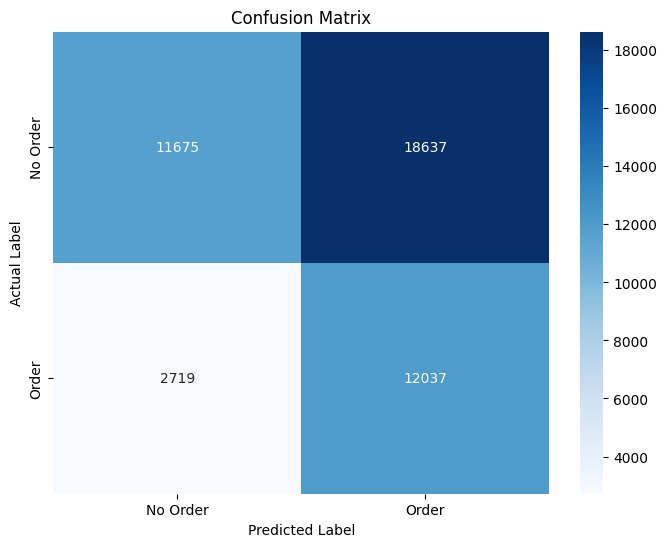

In [1064]:
# 2. Menggabungkan pred dan realclass berdasarkan field sesi
comparison = pd.merge(pred, realclass, on='sessionNo', suffixes=('_predicted', '_actual'))

# 3. Hitung akurasi dan metrik evaluasi lainnya
accuracy = accuracy_score(comparison['predicted_order'], comparison['prediction'])
class_report = classification_report(comparison['predicted_order'], comparison['prediction'])

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(class_report)

# 4. Confusion Matrix
conf_matrix = confusion_matrix(comparison['predicted_order'], comparison['prediction'])

# Visualisasi Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Order', 'Order'], yticklabels=['No Order', 'Order'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

**Analisis Hasil**

Akurasi Model:

Model mencapai akurasi sekitar 52.6%. Ini menunjukkan bahwa model hanya berhasil mengklasifikasikan lebih dari setengah dari total data dengan benar, yang mungkin tidak cukup baik tergantung pada konteks aplikasi.

Precision, Recall, dan F1-Score:

Precision untuk kelas 0 (tidak ada order): 0.81 (tinggi)
Artinya, dari semua prediksi yang dilakukan untuk kelas ini, 81% benar.

Recall untuk kelas 0: 0.39 (rendah)
Menunjukkan bahwa hanya 39% dari semua instance kelas ini yang berhasil dikenali dengan benar oleh model.

F1-Score untuk kelas 0: 0.52
Merupakan kombinasi dari precision dan recall, menunjukkan performa yang sedang.

Precision untuk kelas 1 (order): 0.39 (rendah)
Hanya 39% dari prediksi untuk kelas ini yang benar.

Recall untuk kelas 1: 0.82 (tinggi)
Model berhasil mengenali 82% dari semua instance kelas ini.

F1-Score untuk kelas 1: 0.53
Mengindikasikan bahwa model dapat menangani kelas ini dengan cukup baik, tetapi masih perlu perbaikan.

Support:
Kelas 0 memiliki lebih banyak contoh (30.312) dibandingkan kelas 1 (14.756), yang dapat menyebabkan model cenderung bias terhadap kelas dengan jumlah lebih banyak.

### **Random forest**

In [1063]:
# Memilih semua fitur numerik dari pred
pred_features = pred_rf.select_dtypes(include=['float64', 'int64']).columns.tolist()

# 2. Menggunakan model untuk memprediksi
pred_rf['predicted_order'] = rf_model.predict(pred_rf[pred_features])

Accuracy: 0.49920120706487975
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.37      0.51     31576
           1       0.35      0.80      0.49     13492

    accuracy                           0.50     45068
   macro avg       0.58      0.59      0.50     45068
weighted avg       0.67      0.50      0.50     45068



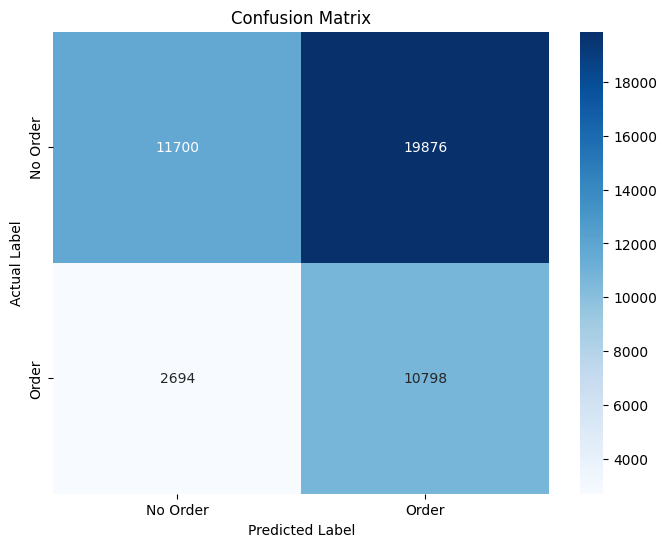

In [1065]:
# 2. Menggabungkan pred dan realclass berdasarkan field sesi
comparison = pd.merge(pred_rf, realclass, on='sessionNo', suffixes=('_predicted', '_actual'))

# 3. Hitung akurasi dan metrik evaluasi lainnya
accuracy = accuracy_score(comparison['predicted_order'], comparison['prediction'])
class_report = classification_report(comparison['predicted_order'], comparison['prediction'])

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(class_report)

# 4. Confusion Matrix
conf_matrix = confusion_matrix(comparison['predicted_order'], comparison['prediction'])

# Visualisasi Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Order', 'Order'], yticklabels=['No Order', 'Order'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

**Analisis Hasil**

Akurasi Model:

Model memiliki akurasi sekitar 49.9%, yang sangat dekat dengan prediksi acak (50%). Ini menunjukkan bahwa model tidak memiliki kekuatan prediksi yang baik dan mungkin kurang efektif dalam mengklasifikasikan data.

Precision, Recall, dan F1-Score:

Precision untuk kelas 0 (tidak ada order): 0.81
Ini menunjukkan bahwa ketika model memprediksi tidak ada order, 81% dari prediksi tersebut benar.

Recall untuk kelas 0: 0.37
Hanya 37% dari semua instance kelas ini yang dikenali dengan benar oleh model. Ini menunjukkan bahwa model tidak dapat menangkap banyak contoh kelas 0.

F1-Score untuk kelas 0: 0.51
Meskipun precision tinggi, recall yang rendah mengakibatkan F1-score yang tidak seimbang.

Precision untuk kelas 1 (order): 0.35
Hanya 35% dari prediksi untuk kelas ini yang benar, menunjukkan masalah yang signifikan dalam prediksi untuk kelas order.

Recall untuk kelas 1: 0.80
Model mampu mengenali 80% dari semua instance kelas ini, tetapi banyak dari prediksi ini tidak akurat (rendahnya precision).

F1-Score untuk kelas 1: 0.49
Kinerja yang sedang, mencerminkan trade-off antara precision dan recall.

Support:
Kelas 0 memiliki lebih banyak contoh (31.576) dibandingkan kelas 1 (13.492), yang berpotensi menyebabkan bias pada model. Kelas mayoritas bisa lebih diutamakan dalam pelatihan, mengabaikan beberapa detail dari kelas minoritas.


## **Kesimpulan**

Hasil dari analisis dan klasifikasi yang telah dilakukan menunjukkan bahwa masih terdapat ruang untuk perbaikan dalam hal akurasi dan performa model. Model awal memberikan gambaran awal tentang bagaimana fitur-fitur mempengaruhi prediksi transaksi, namun masih memerlukan tuning dan pengujian lebih lanjut untuk meningkatkan hasil. Pada revisi berikutnya, kami akan mencoba melakukan analisis lebih lanjut terhadap data, termasuk feature engineering dan tuning hyperparameter model untuk meningkatkan kinerja prediksi. Oleh karena itu, tugas ini belum sepenuhnya selesai dan masih memerlukan langkah-langkah lanjutan untuk mencapai hasil yang optimal.